# Automobile Customer Segmentation: Unsupervised Machine Learning Investigation
Dataset
- Sales team at an automobile company has classified all customers into 4 segments (A, B, C, D ). A strategy of performing segmented outreach and communication has worked exceptionally well for them. 

Objective
- Can an unsupervised machine learning (ML) model predict the 4 segments?
    - or
- Is domain knowledge and further data required?

Approach
- Took training dataset and removed A-D segmentation to review against unsupervised ML results

Modelling approach
- Data preparation
    - Regularisation
        - Scaled by Z scale, Robust scale and Min max scale
        - Normalised by L1, L2 or Max normalisation
- PCA of original, scaled and normalised
- Unsupervised modelling
    - Forcing to 4 categories (k = 4) to match target set even if not optimal
    - K means (Km) clustering
        - Default settings, random state set to limit variation from setting initial centroids
        - K assessment using elbow method and silhouette score
     - Agglomerative (Aggl)/Hierarchical clustering
        - metric= "Euclidean", linkage = "ward”
        - Deterministic, random state not required
        - K assessment using silhouette score

LINKED NOTEBOOK*
- Original Notebook (Customer Segmentation_ unsupervised learning_DBoland Feb 25.ipynb) - this notebook generated to look at affect of less features on models - Copied notebook, remodelled data for less factors and re-ran subsequent code

Future work/improvements
- Iterative approach taken – function or pipeline would reduce coding lines for review

Reference – Kaggle: Customer Segmentation Vetrivel-PS https://www.kaggle.com/datasets/vetrirah/customer/data License

# 1. Import Libraries

In [345]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer,  MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 2. Exploratory data analysis
# 2.1  Initial exploration

In [346]:
# load data
training_data = pd.read_csv("Train.csv")
# view data
training_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [347]:
# information on dataset
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


Only ID, gender, age, spending_score and segmentation have full data

In [348]:
# check for duplicate rows
duplic_check = training_data.drop_duplicates()
duplic_check.info()
# same row number as main data set - no duplicates 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [349]:
# describe dataset statistics
training_data.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [350]:
# value counts if datatype is a string
for i in training_data:
    data_type = training_data[i].dtype
    if data_type == "object":
        value_count = training_data[i].value_counts()
        print("\n",value_count)


 Gender
Male      4417
Female    3651
Name: count, dtype: int64

 Ever_Married
Yes    4643
No     3285
Name: count, dtype: int64

 Graduated
Yes    4968
No     3022
Name: count, dtype: int64

 Profession
Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: count, dtype: int64

 Spending_Score
Low        4878
Average    1974
High       1216
Name: count, dtype: int64

 Var_1
Cat_6    5238
Cat_4    1089
Cat_3     822
Cat_2     422
Cat_7     203
Cat_1     133
Cat_5      85
Name: count, dtype: int64

 Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64


# 2.2 Handling null values and Data transformation of catergorical variables

Only ID, gender, age, spending_score and segmentation have full data

In [351]:
# Create a table of null data to review 


# Filter rows with any NaN values

training_with_nulls = training_data[training_data.isnull().any(axis=1)]
# check data
#training_with_nulls.sort_values('Parch',ascending=False).head(15)
training_with_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1403 entries, 1 to 8063
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               1403 non-null   int64  
 1   Gender           1403 non-null   object 
 2   Ever_Married     1263 non-null   object 
 3   Age              1403 non-null   int64  
 4   Graduated        1325 non-null   object 
 5   Profession       1279 non-null   object 
 6   Work_Experience  574 non-null    float64
 7   Spending_Score   1403 non-null   object 
 8   Family_Size      1068 non-null   float64
 9   Var_1            1327 non-null   object 
 10  Segmentation     1403 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 131.5+ KB


In [352]:
# Create a table of null Profession data to review 


# Filter rows with any NaN values

training_with_nulls = training_data[training_data.isnull().Profession]
# check data
training_with_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 79 to 8063
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               124 non-null    int64  
 1   Gender           124 non-null    object 
 2   Ever_Married     120 non-null    object 
 3   Age              124 non-null    int64  
 4   Graduated        117 non-null    object 
 5   Profession       0 non-null      object 
 6   Work_Experience  98 non-null     float64
 7   Spending_Score   124 non-null    object 
 8   Family_Size      112 non-null    float64
 9   Var_1            121 non-null    object 
 10  Segmentation     124 non-null    object 
dtypes: float64(2), int64(2), object(7)
memory usage: 11.6+ KB


In [353]:
training_with_nulls.T

,79,118,219,237,437,440,498,545,601,641,...,7529,7633,7678,7717,7725,7743,7870,7899,7935,8063
ID,466567,465827,465837,467252,461410,460532,459656,466009,466522,465538,...,459752,464936,460824,462628,467357,467388,462301,464548,464977,464018
Gender,Female,Male,Male,Female,Male,Female,Male,Female,Male,Male,...,Female,Male,Male,Female,Male,Male,Female,Female,Female,Male
Ever_Married,No,No,No,No,Yes,No,No,No,NaN,Yes,...,Yes,No,Yes,Yes,Yes,No,No,Yes,Yes,No
Age,49,27,62,33,79,18,22,32,18,62,...,63,28,66,28,60,35,27,47,66,22
Graduated,Yes,No,Yes,Yes,No,No,No,No,No,No,...,Yes,No,Yes,No,Yes,NaN,No,No,No,No
Profession,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Work_Experience,1.0,2.0,0.0,0.0,0.0,0.0,NaN,10.0,6.0,7.0,...,NaN,1.0,0.0,NaN,0.0,0.0,12.0,1.0,1.0,0.0
Spending_Score,Low,Low,Low,Low,Average,Low,Low,Low,High,High,...,Average,Low,Low,Average,Low,Low,Low,Low,Average,Low
Family_Size,1.0,7.0,1.0,4.0,2.0,6.0,6.0,5.0,4.0,2.0,...,3.0,1.0,2.0,3.0,2.0,NaN,3.0,1.0,2.0,7.0
Var_1,Cat_6,Cat_4,Cat_6,NaN,NaN,Cat_6,Cat_1,Cat_6,Cat_3,Cat_6,...,Cat_6,Cat_4,Cat_2,Cat_4,Cat_6,Cat_6,Cat_6,Cat_4,Cat_4,Cat_1


In [354]:
training_with_nulls.describe()

,ID,Age,Work_Experience,Family_Size
count,124.000000,124.000000,98.000000,112.000000
mean,463258.701613,42.322581,2.397959,2.767857
std,2774.779912,16.129833,3.232374,1.605072
min,458996.000000,18.000000,0.000000,1.000000
25%,460550.000000,31.000000,0.000000,2.000000
50%,463148.000000,39.000000,1.000000,2.000000
75%,465827.750000,56.000000,3.000000,4.000000
max,467798.000000,88.000000,12.000000,8.000000


Thought might be mostly retired or students that have no profession assigned but stats look same as main dataset

In [355]:
# Create a table of null PEver married data to review 


# Filter rows with any NaN values

training_with_nulls = training_data[training_data.isnull().Ever_Married]
# check data
#training_with_nulls.sort_values('Parch',ascending=False).head(15)
training_with_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 24 to 8044
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               140 non-null    int64  
 1   Gender           140 non-null    object 
 2   Ever_Married     0 non-null      object 
 3   Age              140 non-null    int64  
 4   Graduated        136 non-null    object 
 5   Profession       136 non-null    object 
 6   Work_Experience  117 non-null    float64
 7   Spending_Score   140 non-null    object 
 8   Family_Size      128 non-null    float64
 9   Var_1            139 non-null    object 
 10  Segmentation     140 non-null    object 
dtypes: float64(2), int64(2), object(7)
memory usage: 13.1+ KB


In [356]:
training_with_nulls.T

,24,108,201,213,272,311,452,508,601,701,...,7582,7588,7615,7643,7656,7756,7775,8011,8030,8044
ID,461021,466466,466065,460516,464841,461989,467520,464645,466522,466370,...,459771,460504,463288,465582,465983,465987,462989,466026,459082,466997
Gender,Female,Female,Male,Female,Male,Female,Male,Male,Male,Female,...,Female,Male,Female,Male,Male,Male,Male,Female,Male,Female
Ever_Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,58,19,19,85,19,57,22,52,18,48,...,30,43,59,40,19,20,32,49,45,50
Graduated,No,No,No,No,No,Yes,No,Yes,No,Yes,...,Yes,No,Yes,Yes,No,No,Yes,No,Yes,No
Profession,Executive,Healthcare,Healthcare,Lawyer,Entertainment,Engineer,Healthcare,Artist,NaN,Artist,...,Doctor,Executive,Artist,Artist,Healthcare,Healthcare,Healthcare,Entertainment,Artist,Engineer
Work_Experience,1.0,6.0,9.0,0.0,0.0,0.0,NaN,1.0,6.0,0.0,...,0.0,NaN,9.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
Spending_Score,Average,Low,Low,High,High,Average,Low,Average,High,Low,...,Low,Average,Average,Low,Low,Low,Low,Low,Low,Low
Family_Size,3.0,5.0,3.0,1.0,3.0,4.0,2.0,5.0,4.0,4.0,...,3.0,3.0,2.0,1.0,3.0,3.0,1.0,1.0,NaN,2.0
Var_1,Cat_3,Cat_3,Cat_3,Cat_3,Cat_4,Cat_2,Cat_6,Cat_4,Cat_3,Cat_2,...,Cat_3,Cat_3,Cat_6,Cat_7,Cat_6,Cat_2,Cat_6,Cat_3,Cat_6,Cat_6


In [357]:
training_with_nulls.describe()

,ID,Age,Work_Experience,Family_Size
count,140.000000,140.000000,117.000000,128.000000
mean,463811.878571,41.292857,2.880342,3.007812
std,2701.242865,16.578350,3.543236,1.559811
min,459062.000000,18.000000,0.000000,1.000000
25%,460734.750000,28.000000,0.000000,2.000000
50%,464757.000000,39.000000,1.000000,3.000000
75%,466157.250000,53.000000,6.000000,4.000000
max,467947.000000,89.000000,14.000000,8.000000


In [358]:
# Labelencode define
label_enc = LabelEncoder()

# Only ID, gender, age, spending_score and segmentation have full data
df_cleaned = training_data

# Apply label encoder to categories 
df_cleaned["Gender_num"]= label_enc.fit_transform(df_cleaned["Gender"]) # male = 1, # female = 0
df_cleaned["SpendSc_num"]= label_enc.fit_transform(df_cleaned["Spending_Score"]) # Average = 0,  high = 1, low = 2 #shouldn't matter based on categorisation - 
#most counts in low vs. expected average (average by differnt standard vs. this customer set tends ot be low?)
df_cleaned["Segmentation_num"]= label_enc.fit_transform(df_cleaned["Segmentation"]) # A-D, 0-3

df_cleaned.T

,0,1,2,3,4,5,6,7,8,9,...,8058,8059,8060,8061,8062,8063,8064,8065,8066,8067
ID,462809,462643,466315,461735,462669,461319,460156,464347,465015,465176,...,460674,460132,463613,465231,463002,464018,464685,465406,467299,461879
Gender,Male,Female,Female,Male,Female,Male,Male,Female,Female,Female,...,Female,Male,Female,Male,Male,Male,Male,Female,Female,Male
Ever_Married,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,...,No,No,Yes,Yes,Yes,No,No,No,No,Yes
Age,22,38,67,67,40,56,32,33,61,55,...,31,39,48,65,41,22,35,33,27,37
Graduated,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,No,Yes,No,No,Yes,Yes,Yes
Profession,Healthcare,Engineer,Engineer,Lawyer,Entertainment,Artist,Healthcare,Healthcare,Engineer,Artist,...,Entertainment,Healthcare,Artist,Artist,Artist,NaN,Executive,Healthcare,Healthcare,Executive
Work_Experience,1.0,NaN,1.0,0.0,NaN,0.0,1.0,1.0,0.0,1.0,...,0.0,3.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0
Spending_Score,Low,Average,Low,High,High,Average,Low,Low,Low,Average,...,Low,Low,Average,Average,High,Low,Low,Low,Low,Average
Family_Size,4.0,3.0,1.0,2.0,6.0,2.0,3.0,3.0,3.0,4.0,...,3.0,2.0,6.0,2.0,5.0,7.0,4.0,1.0,4.0,3.0
Var_1,Cat_4,Cat_4,Cat_6,Cat_6,Cat_6,Cat_6,Cat_6,Cat_6,Cat_7,Cat_6,...,Cat_3,Cat_6,Cat_6,Cat_6,Cat_6,Cat_1,Cat_4,Cat_6,Cat_6,Cat_4


In [359]:
# pivot table to review work experience
df_cleaned['agebin'] = pd.cut(df_cleaned["Age"], [17,25,30,40,50,60,90])
df_cleaned['Workexpbin'] = pd.cut(df_cleaned["Work_Experience"], [-0.1,0,1,3,5,10,15])


pvtdf =df_cleaned.pivot_table(index=["Profession"], columns=['agebin',"Workexpbin"], values=["ID"], aggfunc=('count'), observed=False).fillna(0)

pvtdf.T

Profession                Artist  Doctor  Engineer  Entertainment  Executive  \
   agebin   Workexpbin                                                         
ID (17, 25] (-0.1, 0.0]        3      26         8             14          5   
            (0.0, 1.0]         9      22        12             21          6   
            (1.0, 3.0]         3       9         0              6          2   
            (3.0, 5.0]         2       5         2              4          1   
            (5.0, 10.0]       14      17        10              7          2   
            (10.0, 15.0]       4       1         2              1          2   
   (25, 30] (-0.1, 0.0]       38      49        35             36          9   
            (0.0, 1.0]        35      45        28             29          7   
            (1.0, 3.0]         8       5         4              4          1   
            (3.0, 5.0]        11       8         6              4          5   
            (5.0, 10.0]       49      23        23             32          6   
            (10.0, 15.0]       8       5         3              6          2   
   (30, 40] (-0.1, 0.0]      156      73        57             60         29   
            (0.0, 1.0]       144      46        57             85         20   
            (1.0, 3.0]        57      11        17             13          6   
            (3.0, 5.0]        60      18        15             19         10   
            (5.0, 10.0]      166      50        44             72         25   
            (10.0, 15.0]      30       9         5             14          2   
   (40, 50] (-0.1, 0.0]      228      39        44             61         40   
            (0.0, 1.0]       242      44        57             63         50   
            (1.0, 3.0]        67       4         7             21         12   
            (3.0, 5.0]        56       6         9             15         10   
            (5.0, 10.0]      134      22        28             37         23   
            (10.0, 15.0]      16       2         2              3          2   
   (50, 60] (-0.1, 0.0]      169      26        35             41         34   
            (0.0, 1.0]       164      18        37             62         39   
            (1.0, 3.0]        52       4         4              4          6   
            (3.0, 5.0]        25       5         5              7          8   
            (5.0, 10.0]       62       2        13             15         18   
            (10.0, 15.0]       2       2         0              0          2   
   (60, 90] (-0.1, 0.0]      116      12        24             32         59   
            (0.0, 1.0]       123      16        21             46         68   
            (1.0, 3.0]        17       1         2             12          5   
            (3.0, 5.0]        14       3         4              3          3   
            (5.0, 10.0]       19       2         8             12          8   
            (10.0, 15.0]       2       0         0              1          1   

Profession                Healthcare  Homemaker  Lawyer  Marketing  
   agebin   Workexpbin                                              
ID (17, 25] (-0.1, 0.0]          204          4       1         18  
            (0.0, 1.0]           187          2       1         19  
            (1.0, 3.0]            46          0       0         11  
            (3.0, 5.0]            36          0       0          4  
            (5.0, 10.0]           97          3       1          6  
            (10.0, 15.0]           7          3       0          1  
   (25, 30] (-0.1, 0.0]           88          5       1         12  
            (0.0, 1.0]            91          3       0         11  
            (1.0, 3.0]            25          4       0          4  
            (3.0, 5.0]            21          1       0          1  
            (5.0, 10.0]           57         37       0         13  
            (10.0, 15.0]           5          6       0       

In [360]:
df_cleaned.describe()

,ID,Age,Work_Experience,Family_Size,Gender_num,SpendSc_num,Segmentation_num
count,8068.000000,8068.000000,7239.000000,7733.000000,8068.000000,8068.000000,8068.000000
mean,463479.214551,43.466906,2.641663,2.850123,0.547471,1.359941,1.561973
std,2595.381232,16.711696,3.406763,1.531413,0.497772,0.848418,1.139029
min,458982.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,461240.750000,30.000000,0.000000,2.000000,0.000000,1.000000,1.000000
50%,463472.500000,40.000000,1.000000,3.000000,1.000000,2.000000,2.000000
75%,465744.250000,53.000000,4.000000,4.000000,1.000000,2.000000,3.000000
max,467974.000000,89.000000,14.000000,9.000000,1.000000,2.000000,3.000000


In [361]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ID                8068 non-null   int64   
 1   Gender            8068 non-null   object  
 2   Ever_Married      7928 non-null   object  
 3   Age               8068 non-null   int64   
 4   Graduated         7990 non-null   object  
 5   Profession        7944 non-null   object  
 6   Work_Experience   7239 non-null   float64 
 7   Spending_Score    8068 non-null   object  
 8   Family_Size       7733 non-null   float64 
 9   Var_1             7992 non-null   object  
 10  Segmentation      8068 non-null   object  
 11  Gender_num        8068 non-null   int64   
 12  SpendSc_num       8068 non-null   int64   
 13  Segmentation_num  8068 non-null   int64   
 14  agebin            8068 non-null   category
 15  Workexpbin        7239 non-null   category
dtypes: category(2), float64(

No loss of rows as plan to only look at features with complete data set

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

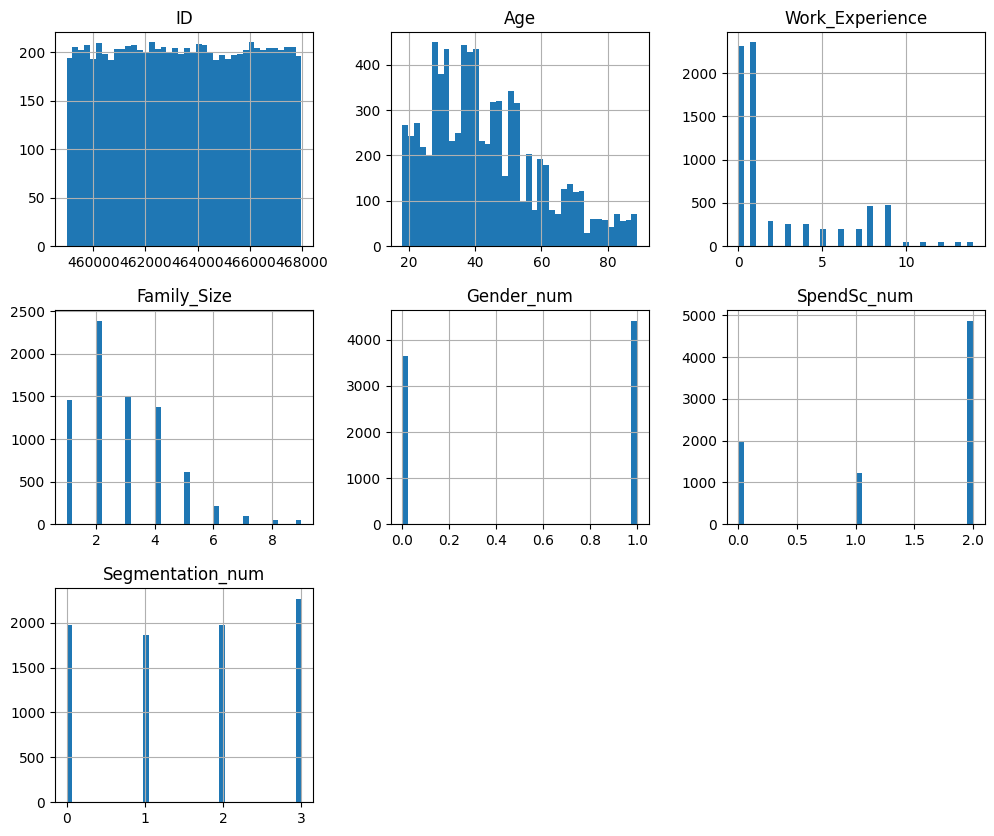

In [362]:
# Visualise distibution of features now have added more
# histogram all numeric data to check data skews at a glance


df_cleaned.hist(bins=40, figsize=(12,10))
plt.tight_layout


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

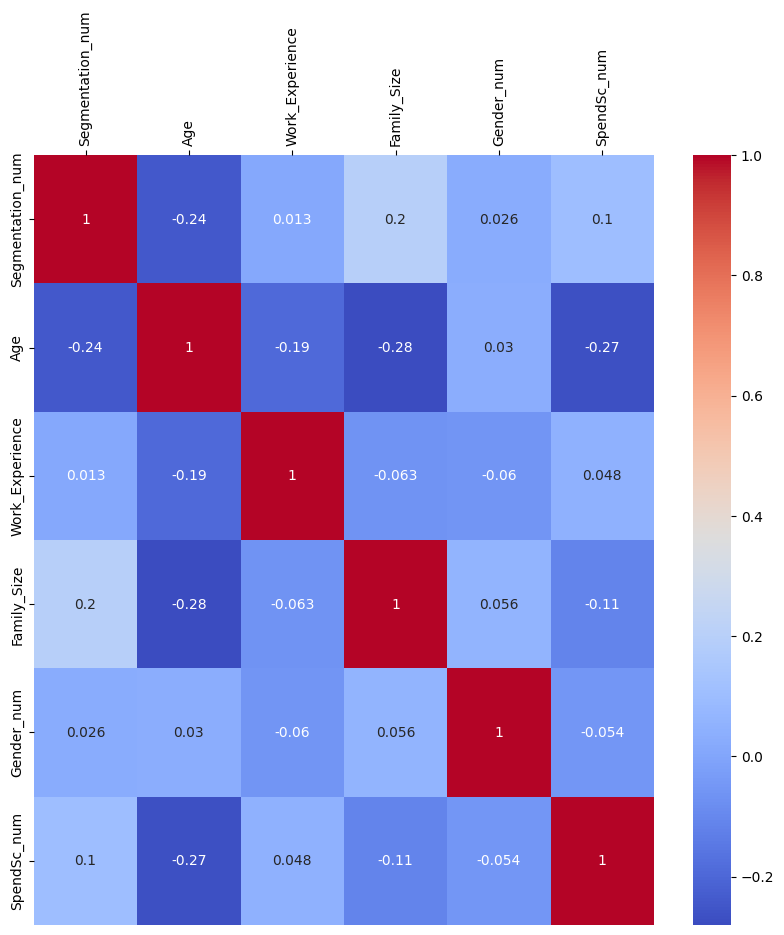

In [363]:
# correlation matrix
plt.figure(figsize=(10,10))
corr_matrix = df_cleaned[["Segmentation_num","Age","Work_Experience","Family_Size","Gender_num","SpendSc_num"]].corr()
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.tight_layout

# 3 Prepare modelling data - Feature scaling vs. normalisation and PCA
# 3.1 Create Modeling dataset

In [364]:
# create modelling data set
# drop Segmentation and Segmentation_num as they are desired output for comparison and drop Work_experience as stated above
# drop categorical columns
# Only ID, gender, age, spending_score and segmentation have full data
model_data = df_cleaned.drop(['Ever_Married', 'Graduated',"Var_1","ID","Gender","Profession","Work_Experience","Spending_Score","Segmentation","Segmentation_num","agebin","Workexpbin","Family_Size"],axis = 1)
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Age          8068 non-null   int64
 1   Gender_num   8068 non-null   int64
 2   SpendSc_num  8068 non-null   int64
dtypes: int64(3)
memory usage: 189.2 KB


# 3.2 Scale Data

In [365]:
# feature scaling
# scaling method apply to same all columns
# robust scalar (extreme outliers, uses median instead of mean as per standard scaler)
sc = StandardScaler()
X_train_zscal = sc.fit_transform(model_data)
X_train_zscal  = pd.DataFrame(X_train_zscal, columns=model_data.columns)


mm = MinMaxScaler(feature_range=(0,10))
X_train_mm = mm.fit_transform(model_data)
X_train_mm  = pd.DataFrame(X_train_mm, columns=model_data.columns)

r = RobustScaler()
X_train_r = r.fit_transform(model_data)
X_train_r  = pd.DataFrame(X_train_r, columns=model_data.columns)

X_train_zscal 

,Age,Gender_num,SpendSc_num
0,-1.284623,0.909164,0.754462
1,-0.327151,-1.099912,-1.603013
2,1.408268,-1.099912,0.754462
3,1.408268,0.909164,-0.424275
4,-0.207467,-1.099912,-0.424275
...,...,...,...
8063,-1.284623,0.909164,0.754462
8064,-0.506677,0.909164,0.754462
8065,-0.626361,-1.099912,0.754462
8066,-0.985413,-1.099912,0.754462


Charts below show scaling changes X axis but no major change to distribution or correlation of dataset

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

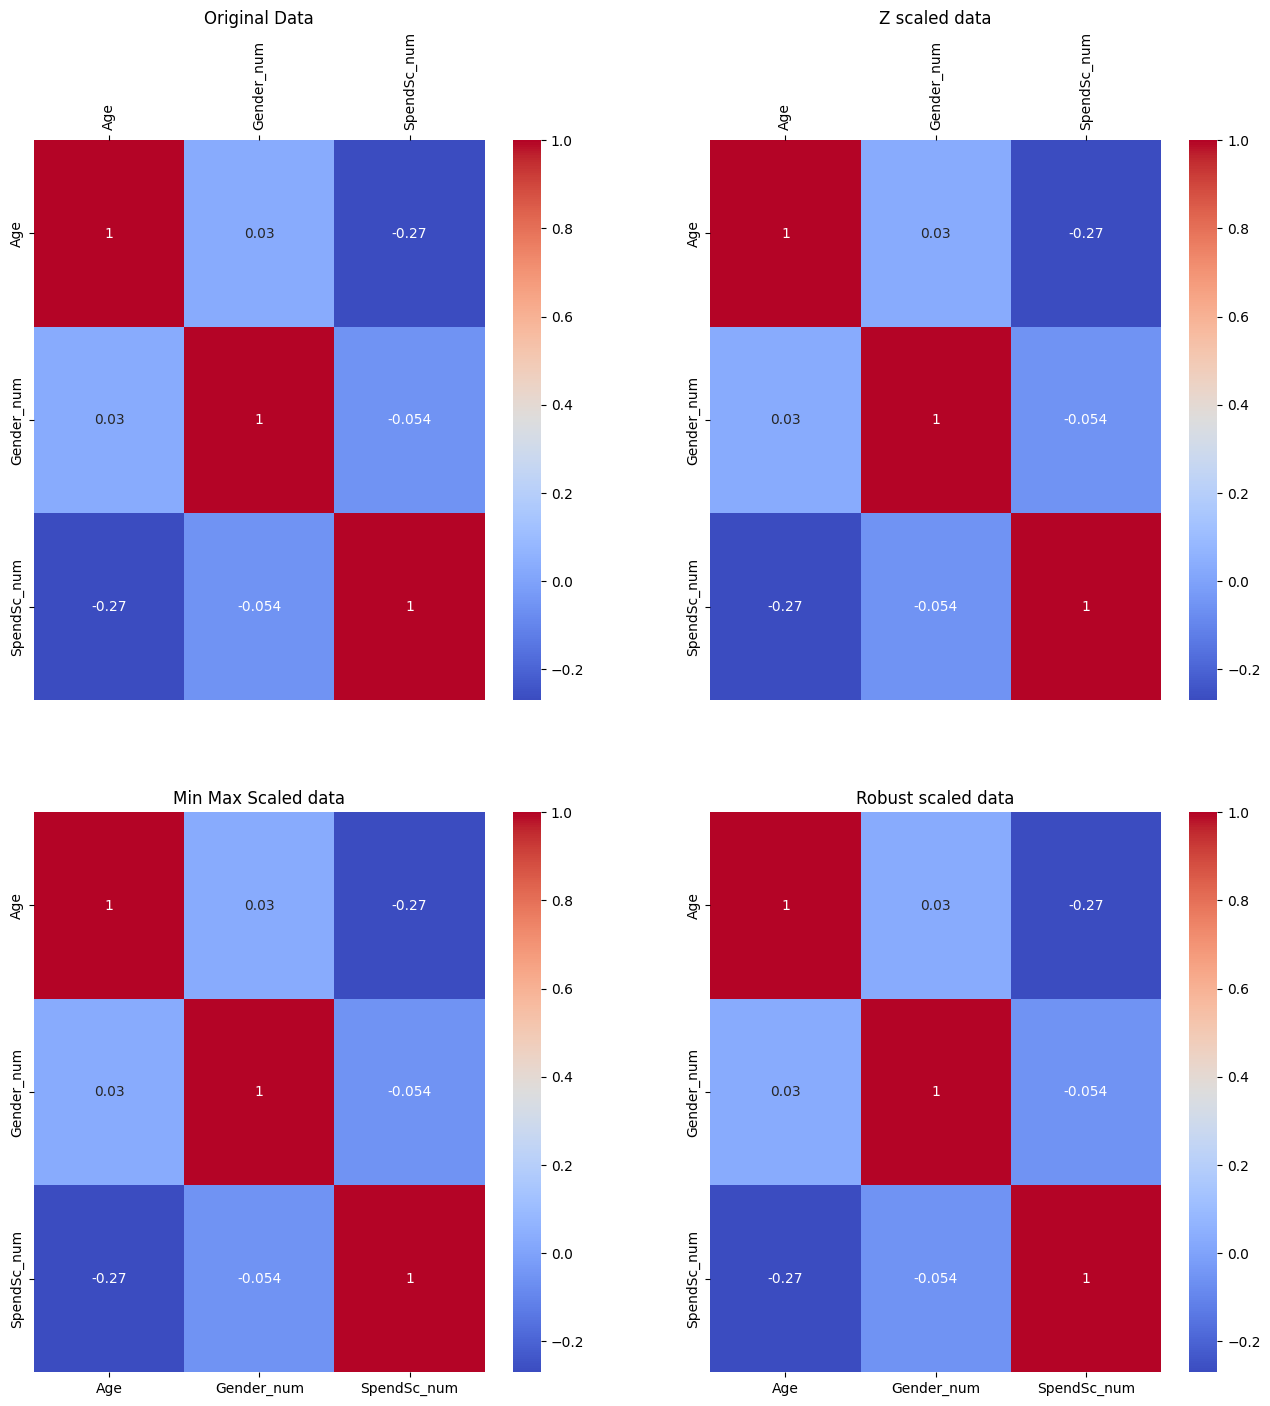

In [366]:
# Plot original and scaled data
fig = plt.figure(figsize=(16,16))

ax = plt.subplot(2, 2, 1)
ax = plt.title('Original Data')
ax = corr_matrix = model_data.corr()
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax.xaxis.tick_top()
ax = plt.xticks(rotation=90)


ax2 = plt.subplot(2, 2, 2)
ax2 = plt.title('Z scaled data')
ax2 = corr_matrix = X_train_zscal.corr()
ax2 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax2.xaxis.tick_top()
ax2 = plt.xticks(rotation=90)

ax3 = plt.subplot(2, 2, 3)
ax3 = plt.title('Min Max Scaled data')
ax3 = corr_matrix = X_train_mm.corr()
ax3 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")


ax4 = plt.subplot(2, 2, 4)
ax4 = plt.title('Robust scaled data')
ax4 = corr_matrix = X_train_r.corr()
ax4 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

plt.tight_layout


Blue is original data, red is zscaled, purple is robust scaled, orange is min max scaled


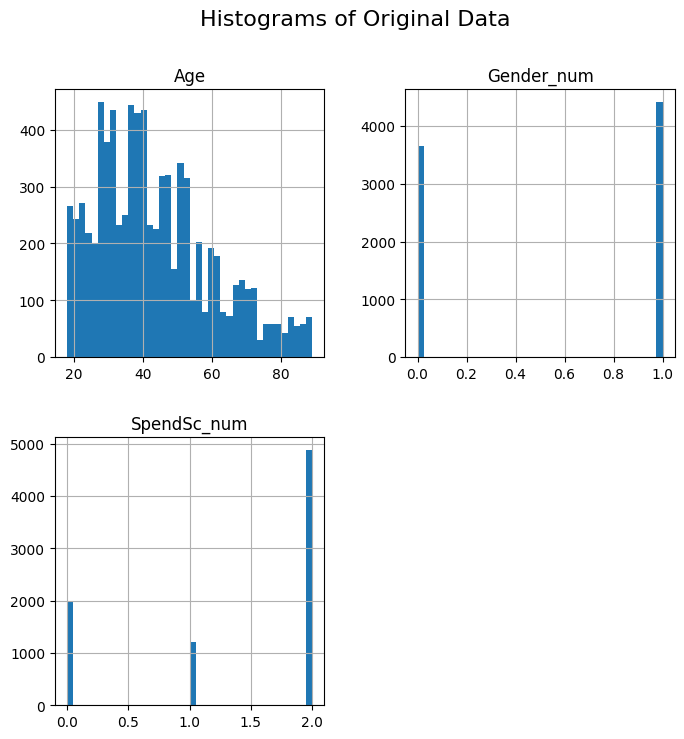

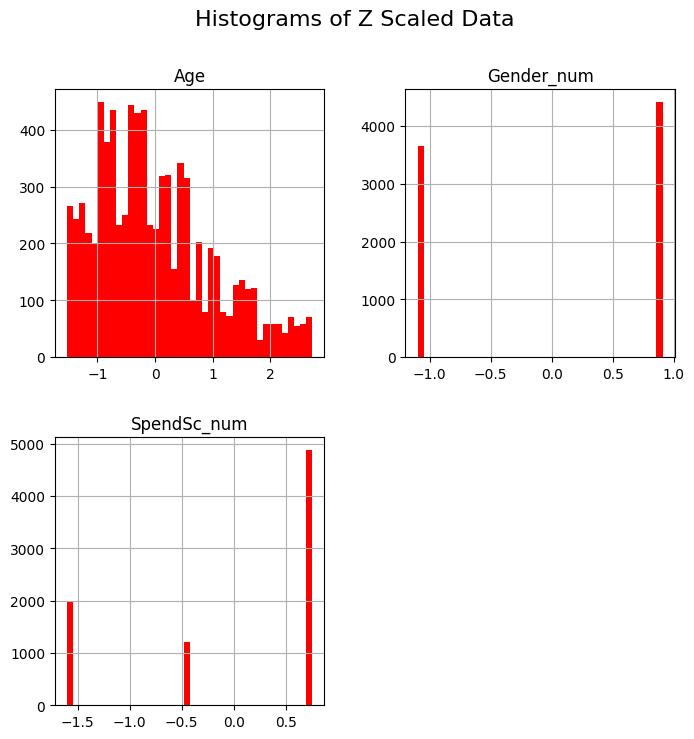

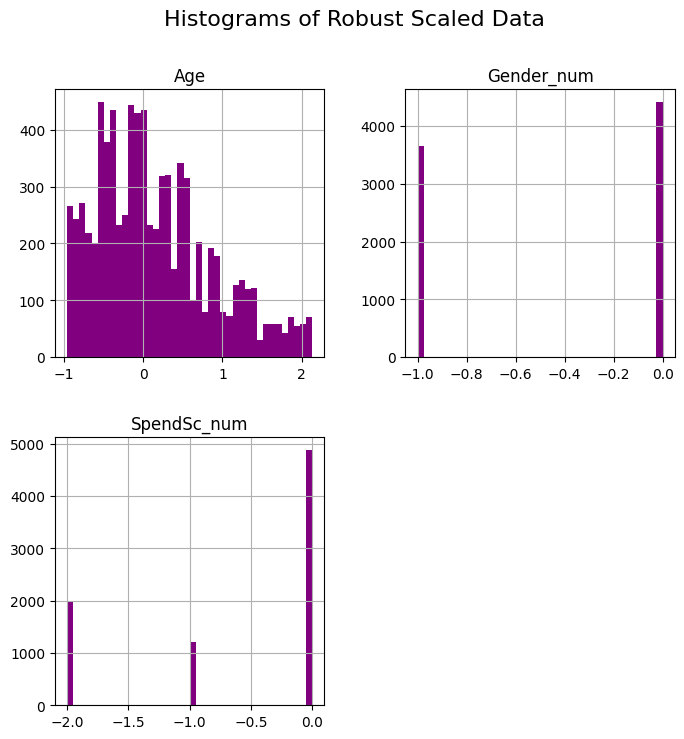

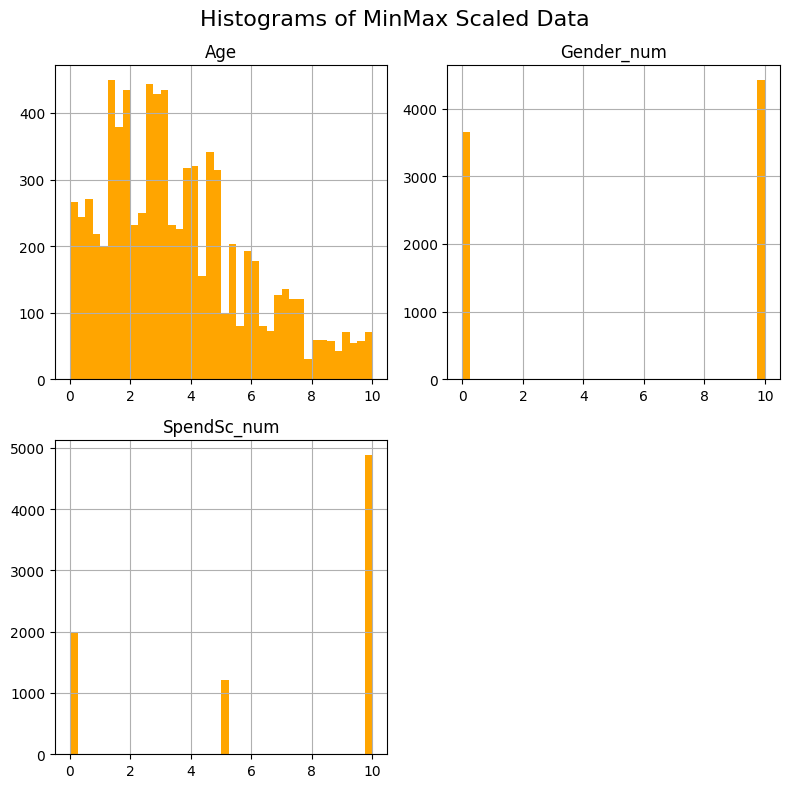

In [367]:
# Plot original and scaled data
print("Blue is original data, red is zscaled, purple is robust scaled, orange is min max scaled")


model_data.hist(bins=40, figsize=(8,8))
plt.suptitle('Histograms of Original Data', fontsize=16)
X_train_zscal.hist(bins=40,  figsize=(8,8), color = "red")
plt.suptitle('Histograms of Z Scaled Data', fontsize=16)
X_train_r.hist(bins=40,  figsize=(8,8), color = "purple")
plt.suptitle('Histograms of Robust Scaled Data', fontsize=16)
X_train_mm.hist(bins=40,  figsize=(8,8), color = "orange")
plt.suptitle('Histograms of MinMax Scaled Data', fontsize=16)

plt.tight_layout()


# 3.3 Normalise 
Normalizer works on each sample (row) independently 
calculates the norm of each sample and then scales the individual features by dividing them by the computed norm. 
A regularization method, e.g. a method to keep the coefficients of the model small, and in turn, the model less complex.
- L1 Norm: aka Manhattan norm - sum of absolute values
- L2 Norm: aka Euclidean norm - square root of the sum of squared values – most common
- Max Norm: Scales each feature by the maximum absolute value in the sample – used neural network weights
References  - https://www.pythonprog.com/sklearn-preprocessing-normalizer/#:~:text=The%20Normalizer%20in%20Scikit-Learn%20focuses%20on%20transforming%20individual,values%20so%20they%20fall%20within%20a%20certain%20range.  https://machinelearningmastery.com/vector-norms-machine-learning/ 

In [368]:
# Normalizer function - L2 Norm: Also known as the Euclidean norm, it’s the square root of the sum of squared values.
normalizerl2 = Normalizer(norm='l2')
# Apply the Normalizer 
X_norm_l2 = normalizerl2.fit_transform(model_data)
X_norm_l2  = pd.DataFrame(X_norm_l2, columns=model_data.columns)
X_norm_l2.head()

,Age,Gender_num,SpendSc_num
0,0.994874,0.045222,0.090443
1,1.000000,0.000000,0.000000
2,0.999555,0.000000,0.029837
3,0.999777,0.014922,0.014922
4,0.999688,0.000000,0.024992


In [369]:
# Normalizer function L1 Norm: Also known as the Manhattan norm, it’s the sum of absolute values. 
normalizerl1 = Normalizer(norm='l1')
# Apply the Normalizer 
X_norm_l1 = normalizerl1.fit_transform(model_data)
X_norm_l1  = pd.DataFrame(X_norm_l1, columns=model_data.columns)
X_norm_l1.head()

,Age,Gender_num,SpendSc_num
0,0.880000,0.040000,0.080000
1,1.000000,0.000000,0.000000
2,0.971014,0.000000,0.028986
3,0.971014,0.014493,0.014493
4,0.975610,0.000000,0.024390


In [370]:
# Normalizer function: Max Norm: Scales each feature by the maximum absolute value in the sample.
normalizermax = Normalizer(norm='max')
# Apply the Normalizer 
X_norm_mx = normalizermax.fit_transform(model_data)
X_norm_mx  = pd.DataFrame(X_norm_mx, columns=model_data.columns)
X_norm_mx.head()

,Age,Gender_num,SpendSc_num
0,1.0,0.045455,0.090909
1,1.0,0.000000,0.000000
2,1.0,0.000000,0.029851
3,1.0,0.014925,0.014925
4,1.0,0.000000,0.025000


In [371]:
X_norm_mx.describe()

,Age,Gender_num,SpendSc_num
count,8068.0,8068.000000,8068.000000
mean,1.0,0.014562,0.039286
std,0.0,0.015487,0.031661
min,1.0,0.000000,0.000000
25%,1.0,0.000000,0.011494
50%,1.0,0.014286,0.039216
75%,1.0,0.025641,0.062500
max,1.0,0.055556,0.111111


Charts below show major shifts to correlation and dataspread of dataset with normalisation. Normalization max in particular turns age from multi to single variable. 

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

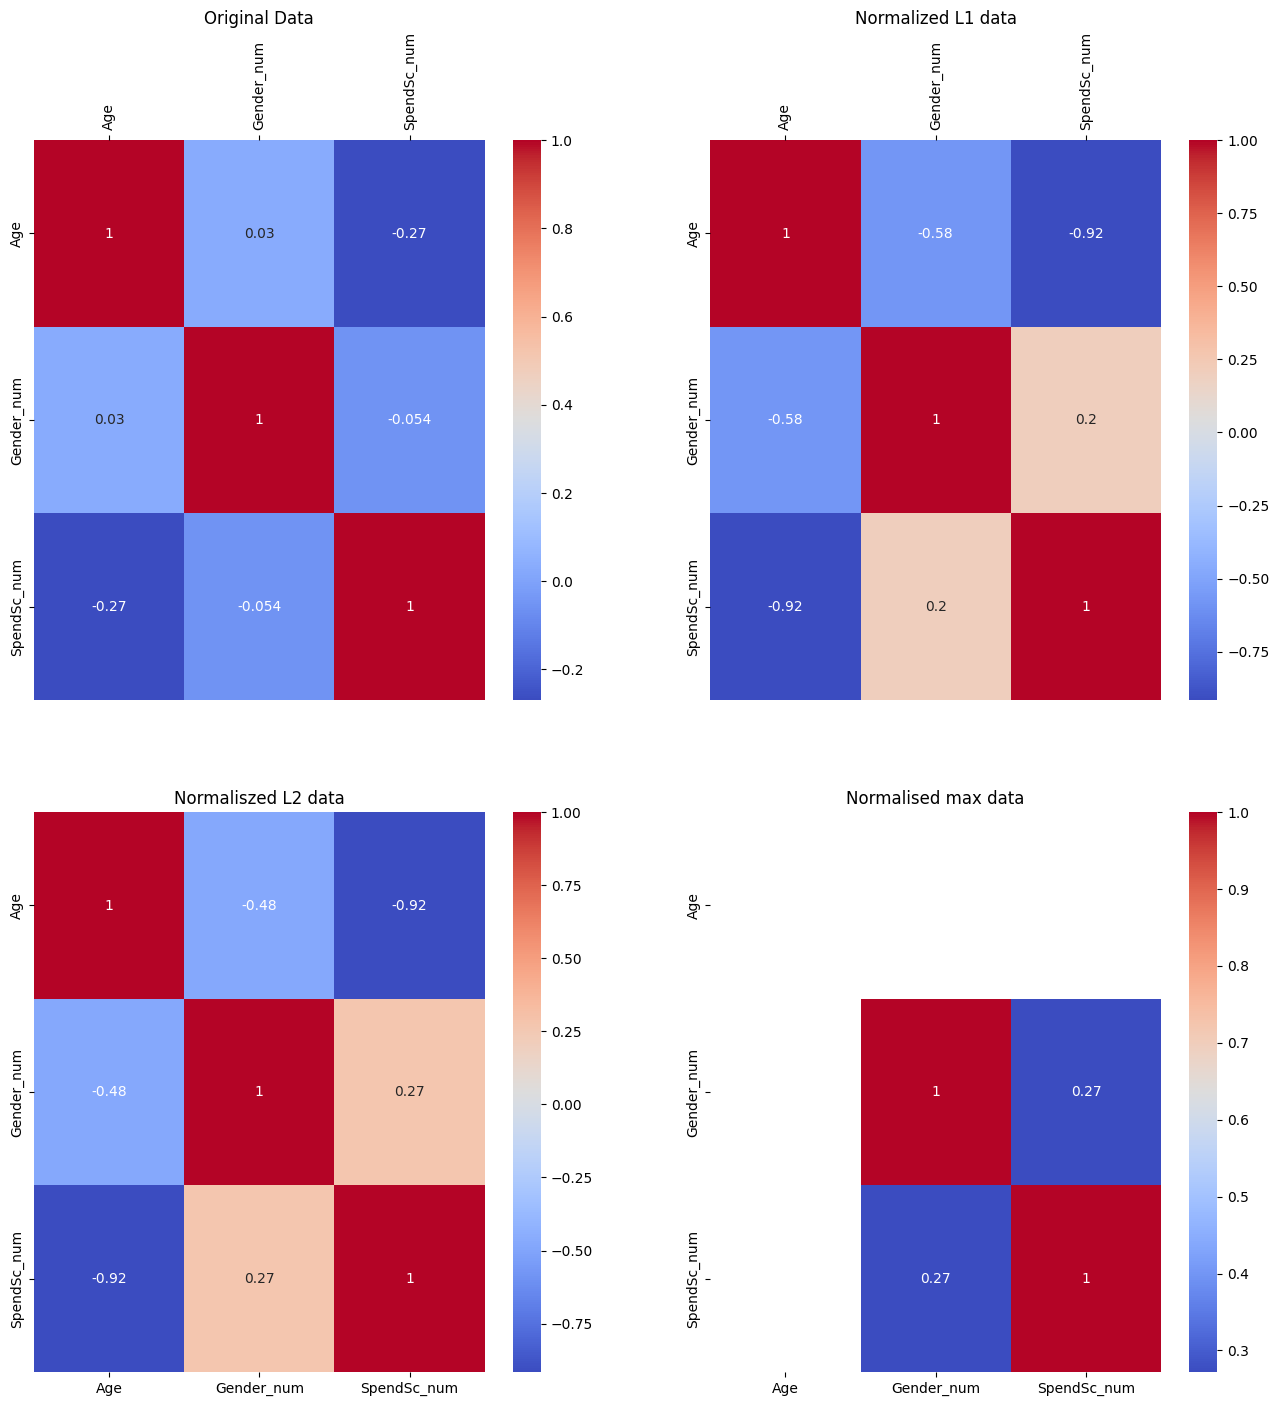

In [372]:
# Plot original and normalized data
fig = plt.figure(figsize=(16,16))

ax = plt.subplot(2, 2, 1)
ax = plt.title('Original Data')
ax = corr_matrix = model_data.corr()
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax.xaxis.tick_top()
ax = plt.xticks(rotation=90)


ax2 = plt.subplot(2, 2, 2)
ax2 = plt.title('Normalized L1 data')
ax2 = corr_matrix = X_norm_l1.corr()
ax2 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax2.xaxis.tick_top()
ax2 = plt.xticks(rotation=90)

ax3 = plt.subplot(2, 2, 3)
ax3 = plt.title('Normaliszed L2 data')
ax3 = corr_matrix = X_norm_l2.corr()
ax3 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")


ax4 = plt.subplot(2, 2, 4)
ax4 = plt.title('Normalised max data')
ax4 = corr_matrix = X_norm_mx.corr()
ax4 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

plt.tight_layout

Blue is original data, red is Normalized L1, purple is Normalized L2, orange is Normalized Max


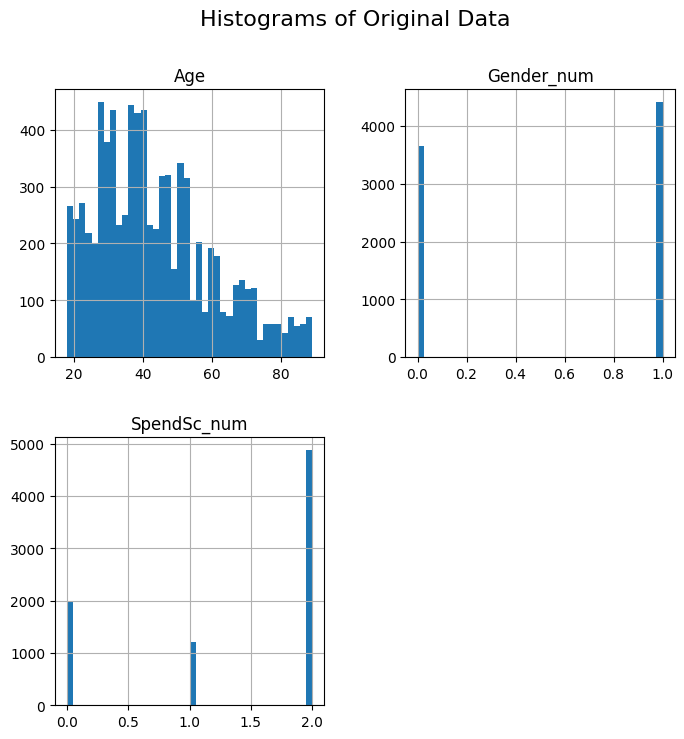

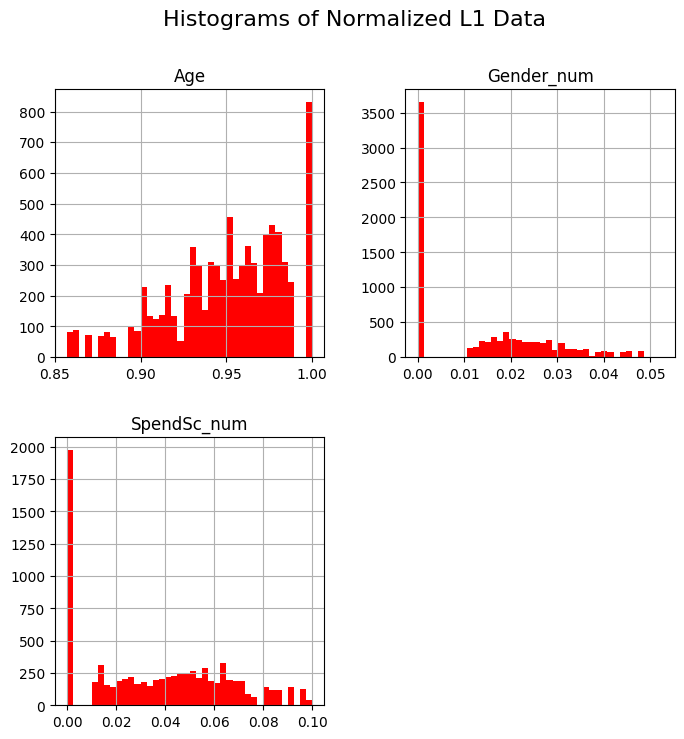

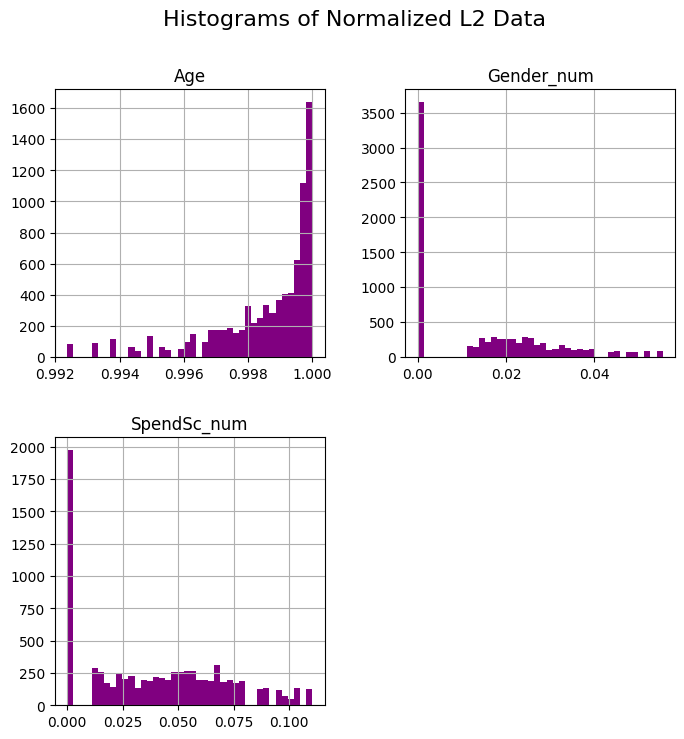

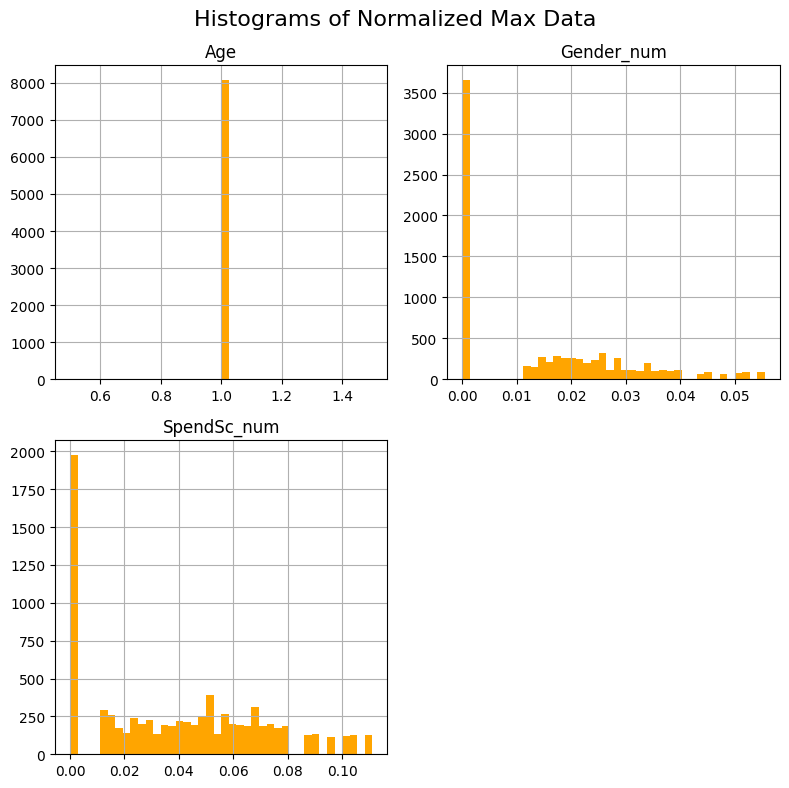

In [373]:
# Plot original and normalized data
print("Blue is original data, red is Normalized L1, purple is Normalized L2, orange is Normalized Max")


model_data.hist(bins=40, figsize=(8,8))
plt.suptitle('Histograms of Original Data', fontsize=16)
X_norm_l1.hist(bins=40,  figsize=(8,8), color = "red")
plt.suptitle('Histograms of Normalized L1 Data', fontsize=16)
X_norm_l2.hist(bins=40,  figsize=(8,8), color = "purple")
plt.suptitle('Histograms of Normalized L2 Data', fontsize=16)
X_norm_mx.hist(bins=40,  figsize=(8,8), color = "orange")
plt.suptitle('Histograms of Normalized Max Data', fontsize=16)

plt.tight_layout()

# 3.4 PCA

In [374]:
# dimensonality reduction PCA
n_components=2
pca = PCA(n_components)

reduced_data_orig = pca.fit_transform(model_data)
reduced_data_orig_table  = pd.DataFrame(reduced_data_orig)
reduced_data_orig_table.columns = ['PCA feat 1', 'PCA feat 2']
print(f"Original data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")

reduced_data_orig_table.head()

Original data Varaiance Ratio: [0.99673525 0.00238464]
Variance covered by 2 component PCA covers 99.91 %


,PCA feat 1,PCA feat 2
0,-21.473249,0.323387
1,-5.448231,-1.408187
2,23.521598,0.988026
3,23.536215,-0.057026
4,-3.462136,-0.381865


In [375]:
reduced_data_orig

array([[-21.47324913,   0.32338692],
       [ -5.44823089,  -1.40818746],
       [ 23.52159797,   0.98802616],
       ...,
       [-10.47519   ,   0.52077271],
       [-16.47462317,   0.43831621],
       [ -6.44723475,  -1.46814575]])

In [376]:
# dimensonality reduction PCA
n_components=3
pca = PCA(n_components)

reduced_data_Zscal = pca.fit_transform(X_train_zscal)
print(f"Z Scaled data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")

Z Scaled data Varaiance Ratio: [0.42740365 0.32947595 0.24312041]
Variance covered by 3 component PCA covers 100.0 %


In [377]:
# dimensonality reduction PCA
n_components=3
pca = PCA(n_components)

reduced_data_rscal = pca.fit_transform(X_train_r)
print(f"Robust Scaled data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")

Robust Scaled data Varaiance Ratio: [0.54620814 0.28888044 0.16491142]
Variance covered by 3 component PCA covers 100.0 %


In [378]:
# dimensonality reduction PCA
n_components=3
pca = PCA(n_components)

reduced_data_mmscal = pca.fit_transform(X_train_mm)
print(f"Min max Scaled data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")

Min max Scaled data Varaiance Ratio: [0.51744391 0.37941996 0.10313613]
Variance covered by 3 component PCA covers 100.0 %


In [379]:
# dimensonality reduction PCA
n_components=2
pca = PCA(n_components)

reduced_data_norml1 = pca.fit_transform(X_norm_l1)
print(f"L1 normalised data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")
print(f"L1 normalised data cumulative varaiance Ratio: {cumulative_var_ratio}")

L1 normalised data Varaiance Ratio: [0.89132923 0.10867077]
Variance covered by 2 component PCA covers 100.0 %
L1 normalised data cumulative varaiance Ratio: [0.89132923 1.        ]


In [380]:
# dimensonality reduction PCA
n_components=2
pca = PCA(n_components)

reduced_data_norml2 = pca.fit_transform(X_norm_l2)
print(f"L2 normalised data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")
print(f"L2 normalised data cumulative varaiance Ratio: {cumulative_var_ratio}")

L2 normalised data Varaiance Ratio: [0.82465899 0.17510654]
Variance covered by 2 component PCA covers 99.98 %
L2 normalised data cumulative varaiance Ratio: [0.82465899 0.99976553]


In [381]:
# dimensonality reduction PCA
n_components=2
pca = PCA(n_components)

reduced_data_normmax = pca.fit_transform(X_norm_mx)
print(f"Max normalised data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")

Max normalised data Varaiance Ratio: [0.82513624 0.17486376]
Variance covered by 2 component PCA covers 100.0 %


# 4 Modelling
# 4.1 K means clustering
Hartigan-Wongs algorithm not attempted would need to import HKMeans. Python automatically chooses the “best” algorithm either Elkan’s algorithm or Lloyd’s

In [382]:
# Generate dataframe to contain expected results and store model results
# specify this is a copy and not a view table to add further columns without error
results = df_cleaned[["ID","Segmentation","Segmentation_num"]].copy()
results.head()

,ID,Segmentation,Segmentation_num
0,462809,D,3
1,462643,A,0
2,466315,B,1
3,461735,B,1
4,462669,A,0


In [383]:
# create shilouette score dataframe with one row
shilscore = pd.DataFrame(index=[0])
# set a cutoff column instead of the Segmentation_num column when comparing silhouette data in results using matrices. Cutoff determined as worked through shilouette scores and only that data saved to results table.
shilscore["cutoff"] = [0.29]
# set k column in case want to add further rows of different k numbers
shilscore["k"] = [4]

shilscore.head()

,cutoff,k
0,0.29,4


# 4.1.1 Original data

In [384]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(model_data)
    sse.append(km.inertia_)
sse

[2260763.7151710535,
 722345.1168764342,
 343115.69394107617,
 195273.64329641854,
 133974.31419791182,
 100160.08983411227,
 72180.62489325865,
 54139.55696118627,
 43906.93448991474]

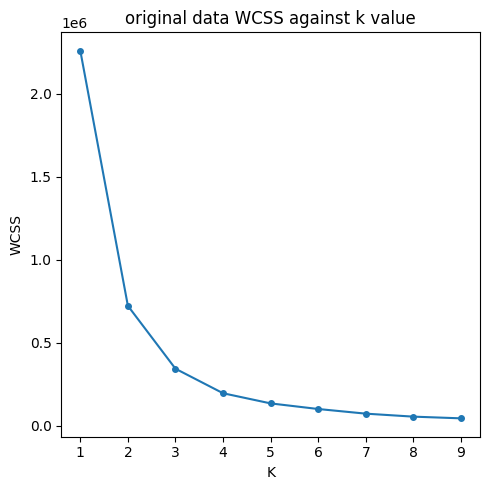

In [385]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("original data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(model_data)

    score = silhouette_score(model_data, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(model_data)
score = silhouette_score(model_data, cluster_labels)
shilscore["Km Orig"] = score

shilscore.head()

Silhouette score for k = 2: 0.5929496360664519
Silhouette score for k = 3: 0.5494034385625817
Silhouette score for k = 4: 0.5398585057174757
Silhouette score for k = 5: 0.5125844184539897
Silhouette score for k = 6: 0.49300197644564114
Silhouette score for k = 7: 0.5020672275124148
Silhouette score for k = 8: 0.4919262968049462
Silhouette score for k = 9: 0.5031367612019707
Silhouette score for k = 10: 0.5027597786704043


,cutoff,k,Km Orig
0,0.29,4,0.539859


In [387]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(model_data)

results["Km Orig"]= y_pred
# cPrint results
print("K Means Original WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.head()



K Means Original WCSS:  195273.64329641854
Iterations until converged:  4
Final Centroids: [[39.70900439  0.51793558  1.2510981 ]
 [75.48957299  0.57795432  1.29195631]
 [54.77141328  0.58190578  0.95877944]
 [25.95489638  0.54164974  1.81308411]]
Cluster assignment 
[3 0 1 ... 0 3 0]


,ID,Segmentation,Segmentation_num,Km Orig
0,462809,D,3,3
1,462643,A,0,0
2,466315,B,1,1
3,461735,B,1,1
4,462669,A,0,0


# 4.1.2 Robust scaled

In [388]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_train_r)
    sse.append(km.inertia_)
sse

[12064.451310833347,
 6402.77792540322,
 4262.38597345396,
 3165.824278951104,
 2765.1921200203633,
 2284.2772639337845,
 1913.6572442183005,
 1665.2278079763346,
 1528.1953405596905]

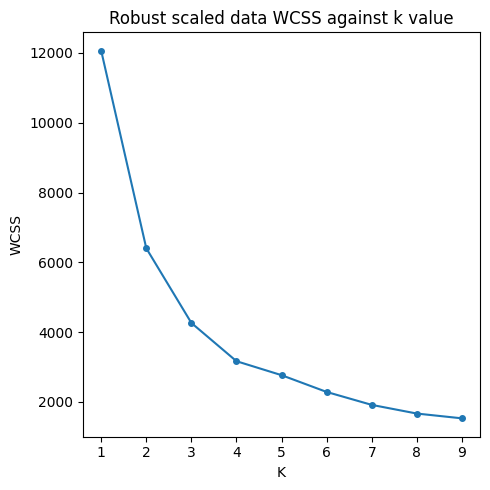

In [389]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Robust scaled data WCSS against k value")
plt.tight_layout()

In [390]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_train_r)

    score = silhouette_score(X_train_r, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_train_r)
score = silhouette_score(X_train_r, cluster_labels)
shilscore["Km RScal"] = score

shilscore.head()

Silhouette score for k = 2: 0.46008771604905885
Silhouette score for k = 3: 0.46470681530198593
Silhouette score for k = 4: 0.4805308109222445
Silhouette score for k = 5: 0.46317271380269176
Silhouette score for k = 6: 0.5047771965123775
Silhouette score for k = 7: 0.5166414189806027
Silhouette score for k = 8: 0.519724406399211
Silhouette score for k = 9: 0.513903286231459
Silhouette score for k = 10: 0.5143767157765595


,cutoff,k,Km Orig,Km RScal
0,0.29,4,0.539859,0.480531


Won't use as didn't elbow out in original 8 feature notebook (refer to intro) and hoping to compare to category of 4

# 4.1.3 Z scaled

In [391]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_train_zscal)
    sse.append(km.inertia_)
sse

[24204.00000000006,
 15748.248600020182,
 11239.015992565344,
 7739.527678092868,
 5113.853792121699,
 3863.143244185985,
 3384.0023901514523,
 3155.988430305156,
 2685.2181103847797]

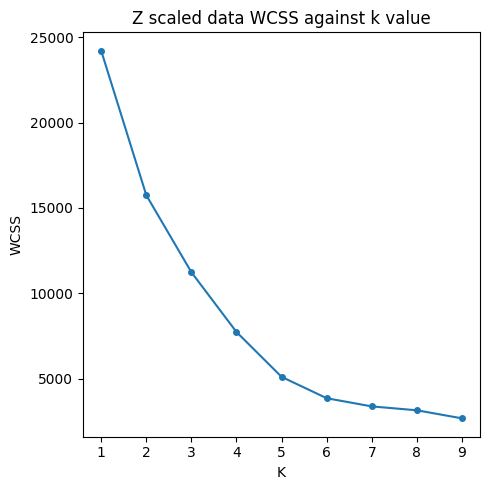

In [392]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Z scaled data WCSS against k value")
plt.tight_layout()

In [393]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_train_zscal)

    score = silhouette_score(X_train_zscal, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_train_zscal)
score = silhouette_score(X_train_zscal, cluster_labels)
shilscore["Km ZScal"] = score

shilscore.head()

Silhouette score for k = 2: 0.37153511233784753
Silhouette score for k = 3: 0.4344546049261904
Silhouette score for k = 4: 0.5029111489173095
Silhouette score for k = 5: 0.5494259669123088
Silhouette score for k = 6: 0.5668857993833206
Silhouette score for k = 7: 0.5367451989110267
Silhouette score for k = 8: 0.5397414203272904
Silhouette score for k = 9: 0.5156247890614544
Silhouette score for k = 10: 0.5069903772332347


,cutoff,k,Km Orig,Km RScal,Km ZScal
0,0.29,4,0.539859,0.480531,0.502911


Won't use as didn't elbow out on original 8 feature otebook (refer to intor) and hoping to compare to category of 4

# 4.1.3 Max min scaled

In [394]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_train_mm)
    sse.append(km.inertia_)
sse

[389742.84440714633,
 189392.7933245556,
 129967.27521345146,
 57399.361056700625,
 47481.29954126728,
 33169.04157831334,
 24773.278173626153,
 21277.826419371988,
 18897.428920508755]

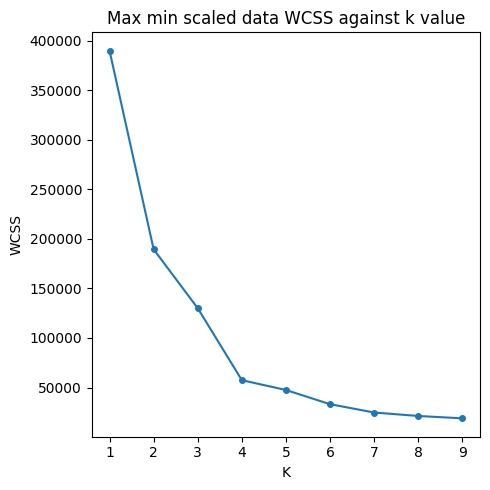

In [395]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Max min scaled data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_train_mm)

    score = silhouette_score(X_train_mm, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_train_mm)
score = silhouette_score(X_train_mm, cluster_labels)
shilscore["Km MMScal"] = score

shilscore.head()

Silhouette score for k = 2: 0.5257952112735579
Silhouette score for k = 3: 0.551042986391455
Silhouette score for k = 4: 0.6468533401166214
Silhouette score for k = 5: 0.6385781544864848
Silhouette score for k = 6: 0.6286811412148112
Silhouette score for k = 7: 0.6453338183641191
Silhouette score for k = 8: 0.6402171842522579
Silhouette score for k = 9: 0.6212727352943783
Silhouette score for k = 10: 0.6279823112625367


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal
0,0.29,4,0.539859,0.480531,0.502911,0.646853


In [397]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(X_train_mm)

results["Km MMScal"]= y_pred
# cPrint results
print("K Means MMSCal WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.head()

K Means MMSCal WCSS:  57399.361056700625
Iterations until converged:  5
Final Centroids: [[ 4.81478713e+00  8.26005930e-14  1.84988628e+00]
 [ 2.99881708e+00  1.00000000e+01  1.00000000e+01]
 [ 2.76991279e+00 -2.39808173e-14  9.99571184e+00]
 [ 4.54140574e+00  1.00000000e+01  1.94221509e+00]]
Cluster assignment 
[1 0 2 ... 2 2 3]


,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal
0,462809,D,3,3,1
1,462643,A,0,0,0
2,466315,B,1,1,2
3,461735,B,1,1,3
4,462669,A,0,0,0


Won't use as doesn't elbow out and hoping to compare to category of 4

# 4.1.4 Normalised L2

In [398]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_norm_l2)
    sse.append(km.inertia_)
sse

[9.956364558048511,
 4.022321363243422,
 2.5747725054981143,
 1.8191636877909265,
 1.4180507469746708,
 1.09864202735268,
 0.8123990863777548,
 0.6653355591888519,
 0.4943440620435937]

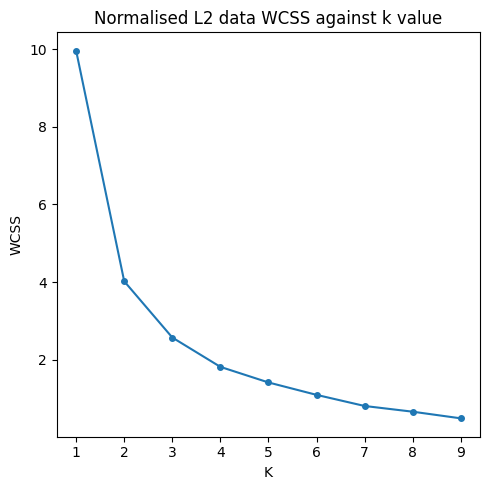

In [399]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Normalised L2 data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_norm_l2)

    score = silhouette_score(X_norm_l2, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_norm_l2)
score = silhouette_score(X_norm_l2, cluster_labels)
shilscore["Km NL2"] = score

shilscore.head()

Silhouette score for k = 2: 0.5027533060046535
Silhouette score for k = 3: 0.46872850202136745
Silhouette score for k = 4: 0.4719791494701224
Silhouette score for k = 5: 0.4701025016597792
Silhouette score for k = 6: 0.47404543871124294
Silhouette score for k = 7: 0.532956355311447
Silhouette score for k = 8: 0.5254821654122755
Silhouette score for k = 9: 0.5675976683245849
Silhouette score for k = 10: 0.5595568949892334


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979


In [401]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(X_norm_l2)

results["Km NL2"]= y_pred
# cPrint results
print("K Means NormL2 WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.head()

K Means NormL2 WCSS:  1.8191636877909265
Iterations until converged:  14
Final Centroids: [[9.99823914e-01 1.20762162e-02 4.87687475e-03]
 [9.97136106e-01 9.88792381e-17 7.41883018e-02]
 [9.95969030e-01 3.94407726e-02 7.85102352e-02]
 [9.99033739e-01 1.14439601e-02 3.96868612e-02]]
Cluster assignment 
[2 0 3 ... 1 1 0]


,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2
0,462809,D,3,3,1,2
1,462643,A,0,0,0,0
2,466315,B,1,1,2,3
3,461735,B,1,1,3,0
4,462669,A,0,0,0,3


# 4.1.5 Normalised L1

In [402]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_norm_l1)
    sse.append(km.inertia_)

sse

[17.542293462649205,
 6.668136385625326,
 3.7565037420886394,
 2.838016461968393,
 2.435513669185881,
 1.9433582823628237,
 1.357733698636473,
 1.059530596314871,
 0.8551453037678176]

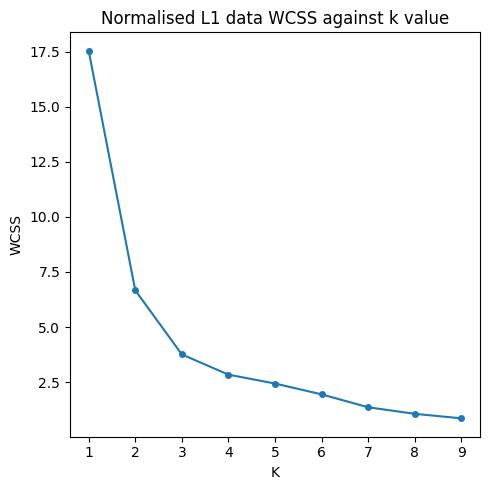

In [403]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Normalised L1 data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_norm_l1)

    score = silhouette_score(X_norm_l1, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_norm_l1)
score = silhouette_score(X_norm_l1, cluster_labels)
shilscore["Km NL1"] = score

shilscore.head()

Silhouette score for k = 2: 0.5137472996166291
Silhouette score for k = 3: 0.48943442065848886
Silhouette score for k = 4: 0.43643023743772924
Silhouette score for k = 5: 0.41344205495465275
Silhouette score for k = 6: 0.4601153993636443
Silhouette score for k = 7: 0.48699953914408
Silhouette score for k = 8: 0.5229226126442166
Silhouette score for k = 9: 0.5458386314959326
Silhouette score for k = 10: 0.5881617256316228


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643


Similar L2 slightly lower shilouette score but very sim

# 4.1.6 Normalised Max

In [405]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_norm_mx)
    sse.append(km.inertia_)

sse

[10.021199545010148,
 4.052285899589588,
 2.591002231021788,
 1.8326472214620928,
 1.4268543591777476,
 1.1054008071799193,
 0.8188201203001249,
 0.6279098459358383,
 0.48192931881794754]

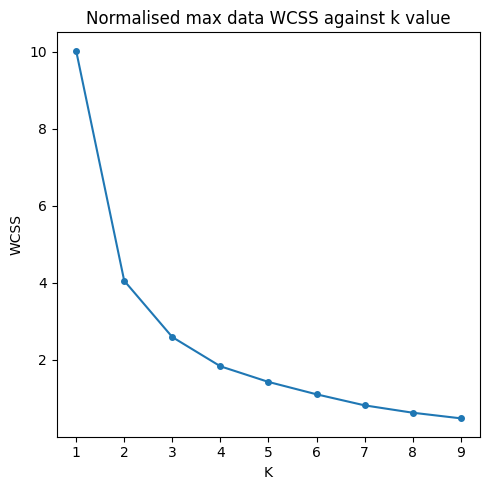

In [406]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Normalised max data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_norm_mx)

    score = silhouette_score(X_norm_mx, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_norm_mx)
score = silhouette_score(X_norm_mx, cluster_labels)
shilscore["Km NMx"] = score

shilscore.head()

Silhouette score for k = 2: 0.5026259884742855
Silhouette score for k = 3: 0.468872256690969
Silhouette score for k = 4: 0.471849809613708
Silhouette score for k = 5: 0.47004103637616595
Silhouette score for k = 6: 0.4739636623821002
Silhouette score for k = 7: 0.53284270673596
Silhouette score for k = 8: 0.5564287526862177
Silhouette score for k = 9: 0.5738739474501032
Silhouette score for k = 10: 0.6077295749548857


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185


Similar L2 and have removed age. Slightly lower score on original 8 feature notebook (refer to intro)

# 4.1.6 PCA original with cluster scatter plot

In [408]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(reduced_data_orig)
    sse.append(km.inertia_)
sse

[2258773.9921123544,
 720357.0501221633,
 341127.94310847664,
 193288.6197828364,
 131994.02727393,
 94216.81245302073,
 65380.33776701981,
 59403.707742130384,
 43405.94221169329]

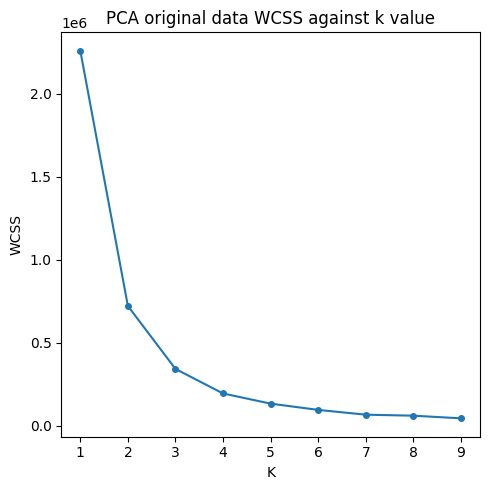

In [409]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("PCA original data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(reduced_data_orig)

    score = silhouette_score(reduced_data_orig, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(reduced_data_orig)
score = silhouette_score(reduced_data_orig, cluster_labels)
shilscore["Km PCA Orig"] = score

shilscore.head()

Silhouette score for k = 2: 0.5946589380716948
Silhouette score for k = 3: 0.5526993287541685
Silhouette score for k = 4: 0.5453964855784891
Silhouette score for k = 5: 0.5201358499634555
Silhouette score for k = 6: 0.5124136282757701
Silhouette score for k = 7: 0.5312407955890271
Silhouette score for k = 8: 0.5210358620325031
Silhouette score for k = 9: 0.5125672586057385
Silhouette score for k = 10: 0.5304031999969874


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396


In [411]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(reduced_data_orig)

results["Km PCA Orig"]= y_pred
# cPrint results
print("K Means PCA Orig WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.tail()

K Means PCA Orig WCSS:  193288.6197828364
Iterations until converged:  5
Final Centroids: [[ -3.75608067  -0.1589947 ]
 [ 32.0206014    0.37076555]
 [ 11.30897229  -0.24693089]
 [-17.51657597   0.21222248]]
Cluster assignment 
[3 0 1 ... 0 3 0]


,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig
8063,464018,D,3,3,1,2,3
8064,464685,D,3,0,1,2,0
8065,465406,D,3,0,2,1,0
8066,467299,B,1,3,2,1,3
8067,461879,B,1,0,3,0,0


,PCA feat 1,PCA feat 2,KmPCAOrig
0,-21.473249,0.323387,3
1,-5.448231,-1.408187,0
2,23.521598,0.988026,1
3,23.536215,-0.057026,1
4,-3.462136,-0.381865,0
...,...,...,...
8063,-21.473249,0.323387,3
8064,-8.474477,0.502043,0
8065,-10.475190,0.520773,0
8066,-16.474623,0.438316,3


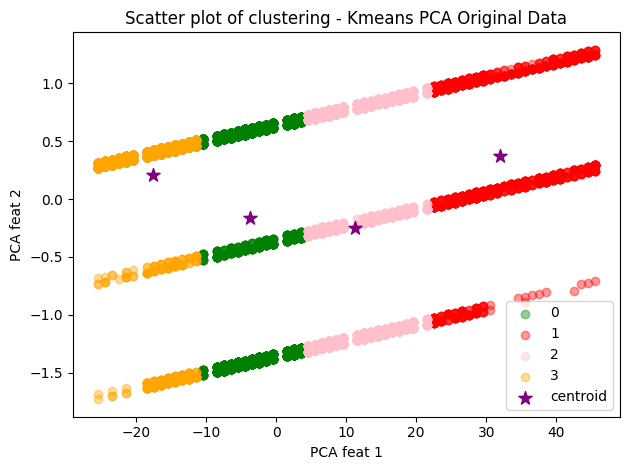

In [412]:
# Scatter plot of clustering

reduced_data_orig_table["KmPCAOrig"] = results["Km PCA Orig"]

df1 = reduced_data_orig_table[reduced_data_orig_table.KmPCAOrig==0]
df2 = reduced_data_orig_table[reduced_data_orig_table.KmPCAOrig==1]
df3 = reduced_data_orig_table[reduced_data_orig_table.KmPCAOrig==2]
df4 = reduced_data_orig_table[reduced_data_orig_table.KmPCAOrig==3]

plt.scatter(df1["PCA feat 1"],df1["PCA feat 2"],color = "green", alpha=0.4, label = 0)
plt.scatter(df2["PCA feat 1"],df2["PCA feat 2"],color = "red",alpha=0.4, label = 1)
plt.scatter(df3["PCA feat 1"],df3["PCA feat 2"],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4["PCA feat 1"],df4["PCA feat 2"],color = "orange", alpha=0.4,label = 3)
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color = "purple", marker = "*", s = 100,label = "centroid")
plt.xlabel("PCA feat 1")
plt.ylabel("PCA feat 2")
plt.legend()
plt.title("Scatter plot of clustering - Kmeans PCA Original Data")
plt.tight_layout()

reduced_data_orig_table


# 4.1.7 PCA Max Min scaled

In [413]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(reduced_data_mmscal)
    sse.append(km.inertia_)
sse

[389742.844407146,
 189392.79332455562,
 129967.27521345147,
 57399.361056700596,
 47481.29954126722,
 33169.04157831338,
 24773.278173626153,
 21277.82641937199,
 18897.428920508748]

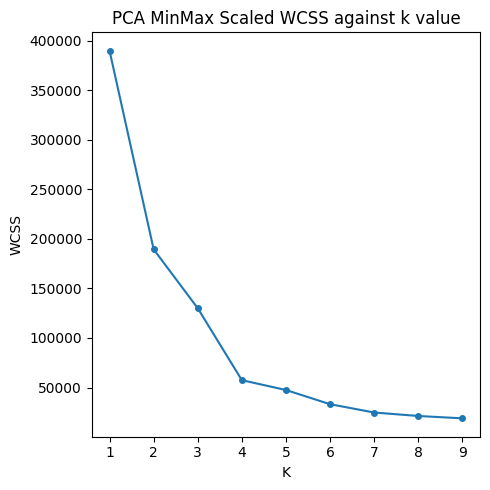

In [414]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("PCA MinMax Scaled WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(reduced_data_mmscal)

    score = silhouette_score(reduced_data_mmscal, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(reduced_data_mmscal)
score = silhouette_score(reduced_data_mmscal, cluster_labels)
shilscore["Km PCA MMScal"] = score

shilscore.head()

Silhouette score for k = 2: 0.5257952112663892
Silhouette score for k = 3: 0.5510429863795987
Silhouette score for k = 4: 0.6468533400976959
Silhouette score for k = 5: 0.6385781544595153
Silhouette score for k = 6: 0.6286811411745374
Silhouette score for k = 7: 0.6453338183004782
Silhouette score for k = 8: 0.6402171841815006
Silhouette score for k = 9: 0.6212727351465445
Silhouette score for k = 10: 0.627982311108904


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,0.646853


In [416]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(reduced_data_mmscal)

results["Km PCA MMScal"]= y_pred
# cPrint results
print("K Means PCA MMScal WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.head()

K Means PCA MMScal WCSS:  57399.361056700596
Iterations until converged:  5
Final Centroids: [[-4.45429522 -6.00710141  0.23432205]
 [ 3.85777213  4.02263158  0.04433949]
 [-5.98390076  2.24329061 -0.122502  ]
 [ 5.35049149 -4.04368764 -0.07296584]]
Cluster assignment 
[1 0 2 ... 2 2 3]


,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal
0,462809,D,3,3,1,2,3,1
1,462643,A,0,0,0,0,0,0
2,466315,B,1,1,2,3,1,2
3,461735,B,1,1,3,0,1,3
4,462669,A,0,0,0,3,0,0


# 4.1.8 PCA L2 norm

In [417]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(reduced_data_norml2)
    sse.append(km.inertia_)
sse

[9.954030077482635,
 4.020036400288793,
 2.5731527142854516,
 1.8204036464337536,
 1.4170443305380176,
 1.0979189794616881,
 0.8117297406668254,
 0.6648475588391303,
 0.4939475851752906]

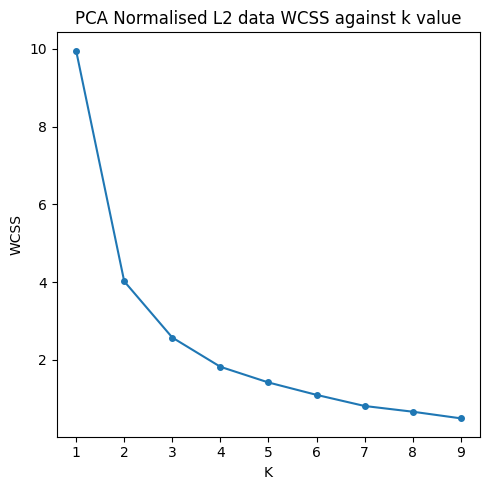

In [418]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("PCA Normalised L2 data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(reduced_data_norml2)

    score = silhouette_score(reduced_data_norml2, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(reduced_data_norml2)
score = silhouette_score(reduced_data_norml2, cluster_labels)
shilscore["Km PCA NL2"] = score

shilscore.head()

Silhouette score for k = 2: 0.5028356095584595
Silhouette score for k = 3: 0.4687833458120039
Silhouette score for k = 4: 0.4719711994347423
Silhouette score for k = 5: 0.47012997931260747
Silhouette score for k = 6: 0.47401749953778105
Silhouette score for k = 7: 0.5329582634182704
Silhouette score for k = 8: 0.5254924323883863
Silhouette score for k = 9: 0.5676116173289146
Silhouette score for k = 10: 0.5595422205788708


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,0.646853,0.471971


In [420]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(reduced_data_norml2)

results["Km PCA NL2"]= y_pred
# cPrint results
print("K Means NormL1 WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.head()

K Means NormL1 WCSS:  1.8204036464337536
Iterations until converged:  12
Final Centroids: [[-0.03436813  0.00324238]
 [ 0.0310038  -0.01994848]
 [ 0.04299519  0.01804193]
 [-0.00050315 -0.00263728]]
Cluster assignment 
[2 0 3 ... 1 1 0]


,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2
0,462809,D,3,3,1,2,3,1,2
1,462643,A,0,0,0,0,0,0,0
2,466315,B,1,1,2,3,1,2,3
3,461735,B,1,1,3,0,1,3,0
4,462669,A,0,0,0,3,0,0,3


# 4.2 Hierarchical clustering
# 4.2.1 Original data 

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(model_data)

    score = silhouette_score(model_data, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(model_data)
score = silhouette_score(model_data, cluster_labels)
shilscore["Aggl Orig"] = score

shilscore.head()


Silhouette score for k = 2: 0.5822310509516694
Silhouette score for k = 3: 0.5542695676960471
Silhouette score for k = 4: 0.5277276392191564
Silhouette score for k = 5: 0.4964887873215303
Silhouette score for k = 6: 0.5112509421609946
Silhouette score for k = 7: 0.49969534091652795
Silhouette score for k = 8: 0.501527746367861
Silhouette score for k = 9: 0.49502809843966333
Silhouette score for k = 10: 0.4977236741862297


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,0.646853,0.471971,0.527728


In [422]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(model_data)
results["Aggl Orig"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig
0,462809,D,3,3,1,2,3,1,2,3
1,462643,A,0,0,0,0,0,0,0,1
2,466315,B,1,1,2,3,1,2,3,2
3,461735,B,1,1,3,0,1,3,0,2
4,462669,A,0,0,0,3,0,0,3,1


Optimal is 2 clusters but will force 4 to try to hit target data

# 4.2.2 Scaled data

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_train_r)

    score = silhouette_score(X_train_r, cluster_labels)
    sil_score.append(score)
    print(f"Robust Scalar - Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_train_r)
score = silhouette_score(X_train_r, cluster_labels)
shilscore["Aggl RScal"] = score

shilscore.head()

Robust Scalar - Silhouette score for k = 2: 0.4247013711966323
Robust Scalar - Silhouette score for k = 3: 0.4630672599915242
Robust Scalar - Silhouette score for k = 4: 0.44474872531785237
Robust Scalar - Silhouette score for k = 5: 0.4678105750028809
Robust Scalar - Silhouette score for k = 6: 0.47663798516822825
Robust Scalar - Silhouette score for k = 7: 0.4850041653037378
Robust Scalar - Silhouette score for k = 8: 0.5057136739296798
Robust Scalar - Silhouette score for k = 9: 0.5037622550360464
Robust Scalar - Silhouette score for k = 10: 0.5025334552619989


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,0.646853,0.471971,0.527728,0.444749


In [424]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_train_zscal)

    score = silhouette_score(X_train_zscal, cluster_labels)
    sil_score.append(score)
    print(f"Z Scale - Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_train_zscal)
score = silhouette_score(X_train_zscal, cluster_labels)
shilscore["Aggl ZScal"] = score
shilscore.head()

Z Scale - Silhouette score for k = 2: 0.35146020634656183
Z Scale - Silhouette score for k = 3: 0.4011692802774847
Z Scale - Silhouette score for k = 4: 0.47245092289704715
Z Scale - Silhouette score for k = 5: 0.5410688066450818
Z Scale - Silhouette score for k = 6: 0.5632560088633417
Z Scale - Silhouette score for k = 7: 0.5297913168872493
Z Scale - Silhouette score for k = 8: 0.5157402057242968
Z Scale - Silhouette score for k = 9: 0.49077656878062625
Z Scale - Silhouette score for k = 10: 0.5192111277481768


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,0.646853,0.471971,0.527728,0.444749,0.472451


In [425]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_train_mm)

    score = silhouette_score(X_train_mm, cluster_labels)
    sil_score.append(score)
    print(f"Min max Scale - Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_train_mm)
score = silhouette_score(X_train_mm, cluster_labels)
shilscore["Aggl MMScal"] = score
shilscore.head()

Min max Scale - Silhouette score for k = 2: 0.4487900619915176
Min max Scale - Silhouette score for k = 3: 0.5704571782611148
Min max Scale - Silhouette score for k = 4: 0.6240323581034185
Min max Scale - Silhouette score for k = 5: 0.6225329966658242
Min max Scale - Silhouette score for k = 6: 0.6230377561761378
Min max Scale - Silhouette score for k = 7: 0.6404793635045415
Min max Scale - Silhouette score for k = 8: 0.6350041362443426
Min max Scale - Silhouette score for k = 9: 0.6356310625958691
Min max Scale - Silhouette score for k = 10: 0.6136559998527902


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,0.646853,0.471971,0.527728,0.444749,0.472451,0.624032


In [426]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(X_train_mm)
results["Aggl MMScal"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal
0,462809,D,3,3,1,2,3,1,2,3,0
1,462643,A,0,0,0,0,0,0,0,1,3
2,466315,B,1,1,2,3,1,2,3,2,1
3,461735,B,1,1,3,0,1,3,0,2,0
4,462669,A,0,0,0,3,0,0,3,1,1




# 4.2.3 Normalisation L2

In [427]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_norm_l2)

    score = silhouette_score(X_norm_l2, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_norm_l2)
score = silhouette_score(X_norm_l2, cluster_labels)
shilscore["Aggl NL2"] = score
shilscore.head()

Silhouette score for k = 2: 0.485545311161892
Silhouette score for k = 3: 0.4729774991004116
Silhouette score for k = 4: 0.4693273581107699
Silhouette score for k = 5: 0.4486345181939047
Silhouette score for k = 6: 0.4747345373533064
Silhouette score for k = 7: 0.4977201830989915
Silhouette score for k = 8: 0.5573921590816479
Silhouette score for k = 9: 0.569356674691341
Silhouette score for k = 10: 0.5945334835427972


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,0.646853,0.471971,0.527728,0.444749,0.472451,0.624032,0.469327


In [428]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(X_norm_l2)
results["Aggl NL2"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2
0,462809,D,3,3,1,2,3,1,2,3,0,2
1,462643,A,0,0,0,0,0,0,0,1,3,0
2,466315,B,1,1,2,3,1,2,3,2,1,1
3,461735,B,1,1,3,0,1,3,0,2,0,0
4,462669,A,0,0,0,3,0,0,3,1,1,0




# 4.2.3 Normalisation L1

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_norm_l1)

    score = silhouette_score(X_norm_l1, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_norm_l1)
score = silhouette_score(X_norm_l1, cluster_labels)
shilscore["Aggl NL1"] = score
shilscore.head()

Silhouette score for k = 2: 0.5029148047927768
Silhouette score for k = 3: 0.38727468021816414
Silhouette score for k = 4: 0.4013155704254586
Silhouette score for k = 5: 0.45579945619156564
Silhouette score for k = 6: 0.4806702770067773
Silhouette score for k = 7: 0.48753639898284423
Silhouette score for k = 8: 0.5087518965340192
Silhouette score for k = 9: 0.525849971889454
Silhouette score for k = 10: 0.5737901806206975


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,0.646853,0.471971,0.527728,0.444749,0.472451,0.624032,0.469327,0.401316


In [430]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(X_norm_l1)
results["Aggl NL1"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2,Aggl NL1
0,462809,D,3,3,1,2,3,1,2,3,0,2,3
1,462643,A,0,0,0,0,0,0,0,1,3,0,1
2,466315,B,1,1,2,3,1,2,3,2,1,1,2
3,461735,B,1,1,3,0,1,3,0,2,0,0,1
4,462669,A,0,0,0,3,0,0,3,1,1,0,1


# 4.2.3 Normalisation Max


In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_norm_mx)

    score = silhouette_score(X_norm_mx, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_norm_mx)
score = silhouette_score(X_norm_mx, cluster_labels)
shilscore["Aggl NMx"] = score
shilscore.head()

Silhouette score for k = 2: 0.4850530393387178
Silhouette score for k = 3: 0.4729774601410337
Silhouette score for k = 4: 0.4693122712572675
Silhouette score for k = 5: 0.44845421031876526
Silhouette score for k = 6: 0.47424975502660305
Silhouette score for k = 7: 0.4975426734357551
Silhouette score for k = 8: 0.5571556248147692
Silhouette score for k = 9: 0.5693443990915036
Silhouette score for k = 10: 0.5944888958575991


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,0.646853,0.471971,0.527728,0.444749,0.472451,0.624032,0.469327,0.401316,0.469312


In [432]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(X_norm_mx)
results["Aggl NMx"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx
0,462809,D,3,3,1,2,3,1,2,3,0,2,3,2
1,462643,A,0,0,0,0,0,0,0,1,3,0,1,0
2,466315,B,1,1,2,3,1,2,3,2,1,1,2,1
3,461735,B,1,1,3,0,1,3,0,2,0,0,1,0
4,462669,A,0,0,0,3,0,0,3,1,1,0,1,0


# 4.2.4 PCA Original with cluster scatter plot


In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_orig)

    score = silhouette_score(reduced_data_orig, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_orig)
score = silhouette_score(reduced_data_orig, cluster_labels)
shilscore["Aggl PCA Orig"] = score
shilscore.head()

Silhouette score for k = 2: 0.6034486610419424
Silhouette score for k = 3: 0.5567007013865691
Silhouette score for k = 4: 0.5453540759199311
Silhouette score for k = 5: 0.5311940731501471
Silhouette score for k = 6: 0.5582137243910786
Silhouette score for k = 7: 0.5647891128274001
Silhouette score for k = 8: 0.5118461464843639
Silhouette score for k = 9: 0.5310380214518658
Silhouette score for k = 10: 0.5093580022910805


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,0.646853,0.471971,0.527728,0.444749,0.472451,0.624032,0.469327,0.401316,0.469312,0.545354


In [434]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(reduced_data_orig)
results["Aggl PCA Orig"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig
0,462809,D,3,3,1,2,3,1,2,3,0,2,3,2,2
1,462643,A,0,0,0,0,0,0,0,1,3,0,1,0,0
2,466315,B,1,1,2,3,1,2,3,2,1,1,2,1,1
3,461735,B,1,1,3,0,1,3,0,2,0,0,1,0,1
4,462669,A,0,0,0,3,0,0,3,1,1,0,1,0,0


,PCA feat 1,PCA feat 2,KmPCAOrig,AgglPCAOrig
0,-21.473249,0.323387,3,2
1,-5.448231,-1.408187,0,0
2,23.521598,0.988026,1,1
3,23.536215,-0.057026,1,1
4,-3.462136,-0.381865,0,0
...,...,...,...,...
8063,-21.473249,0.323387,3,2
8064,-8.474477,0.502043,0,0
8065,-10.475190,0.520773,0,2
8066,-16.474623,0.438316,3,2


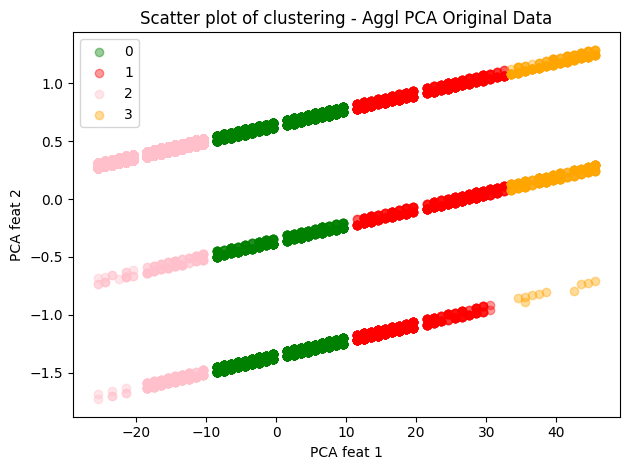

In [435]:
# Scatter plot of clustering

reduced_data_orig_table["AgglPCAOrig"] = results["Aggl PCA Orig"]

df1 = reduced_data_orig_table[reduced_data_orig_table.AgglPCAOrig==0]
df2 = reduced_data_orig_table[reduced_data_orig_table.AgglPCAOrig==1]
df3 = reduced_data_orig_table[reduced_data_orig_table.AgglPCAOrig==2]
df4 = reduced_data_orig_table[reduced_data_orig_table.AgglPCAOrig==3]

plt.scatter(df1["PCA feat 1"],df1["PCA feat 2"],color = "green", alpha=0.4, label = 0)
plt.scatter(df2["PCA feat 1"],df2["PCA feat 2"],color = "red", alpha=0.4, label = 1)
plt.scatter(df3["PCA feat 1"],df3["PCA feat 2"],color = "pink", alpha=0.4, label = 2)
plt.scatter(df4["PCA feat 1"],df4["PCA feat 2"],color = "orange", alpha=0.4, label = 3)
plt.xlabel("PCA feat 1")
plt.ylabel("PCA feat 2")
plt.legend()
plt.title("Scatter plot of clustering - Aggl PCA Original Data")
plt.tight_layout()

reduced_data_orig_table

# 4.2.5 PCA Scaled

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_rscal)

    score = silhouette_score(reduced_data_rscal, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_rscal)
score = silhouette_score(reduced_data_rscal, cluster_labels)
shilscore["Aggl PCA RScal"] = score
shilscore.head()

Silhouette score for k = 2: 0.42308407670150006
Silhouette score for k = 3: 0.4704196961288997
Silhouette score for k = 4: 0.4755741834525535
Silhouette score for k = 5: 0.4560737455603408
Silhouette score for k = 6: 0.5029821486245584
Silhouette score for k = 7: 0.5101485666737045
Silhouette score for k = 8: 0.4952618388050759
Silhouette score for k = 9: 0.4995279132866358
Silhouette score for k = 10: 0.5177132575450477


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,...,0.471971,0.527728,0.444749,0.472451,0.624032,0.469327,0.401316,0.469312,0.545354,0.475574


In [437]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_Zscal)

    score = silhouette_score(reduced_data_Zscal, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_Zscal)
score = silhouette_score(reduced_data_Zscal, cluster_labels)
shilscore["Aggl PCA ZScal"] = score
shilscore.head()

Silhouette score for k = 2: 0.33429971606283704
Silhouette score for k = 3: 0.3919503880678849
Silhouette score for k = 4: 0.47222815860211154
Silhouette score for k = 5: 0.527172843332919
Silhouette score for k = 6: 0.5469896304491644
Silhouette score for k = 7: 0.5357896403985142
Silhouette score for k = 8: 0.5105629545010396
Silhouette score for k = 9: 0.5103830863968168
Silhouette score for k = 10: 0.5209170109561055


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal,Aggl PCA ZScal
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,...,0.527728,0.444749,0.472451,0.624032,0.469327,0.401316,0.469312,0.545354,0.475574,0.472228


In [438]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(reduced_data_Zscal)
results["Aggl PCA ZScal"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA ZScal
0,462809,D,3,3,1,2,3,1,2,3,0,2,3,2,2,3
1,462643,A,0,0,0,0,0,0,0,1,3,0,1,0,0,0
2,466315,B,1,1,2,3,1,2,3,2,1,1,2,1,1,1
3,461735,B,1,1,3,0,1,3,0,2,0,0,1,0,1,1
4,462669,A,0,0,0,3,0,0,3,1,1,0,1,0,0,0


In [439]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_mmscal)

    score = silhouette_score(reduced_data_mmscal, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_mmscal)
score = silhouette_score(reduced_data_mmscal, cluster_labels)
shilscore["Aggl PCA MMScal"] = score
shilscore.head()

Silhouette score for k = 2: 0.44879006198527577
Silhouette score for k = 3: 0.5704571782481271
Silhouette score for k = 4: 0.6240323580838086
Silhouette score for k = 5: 0.6225329966299457
Silhouette score for k = 6: 0.6230377561361469
Silhouette score for k = 7: 0.6404793634542931
Silhouette score for k = 8: 0.635004136187536
Silhouette score for k = 9: 0.6356310625340218
Silhouette score for k = 10: 0.6136559996784565


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal,Aggl PCA ZScal,Aggl PCA MMScal
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,...,0.444749,0.472451,0.624032,0.469327,0.401316,0.469312,0.545354,0.475574,0.472228,0.624032


In [440]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(reduced_data_mmscal)
results["Aggl PCA MMScal"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA ZScal,Aggl PCA MMScal
0,462809,D,3,3,1,2,3,1,2,3,0,2,3,2,2,3,0
1,462643,A,0,0,0,0,0,0,0,1,3,0,1,0,0,0,3
2,466315,B,1,1,2,3,1,2,3,2,1,1,2,1,1,1,1
3,461735,B,1,1,3,0,1,3,0,2,0,0,1,0,1,1,0
4,462669,A,0,0,0,3,0,0,3,1,1,0,1,0,0,0,1


# 4.2.5 PCA Normalized

In [441]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_norml1)

    score = silhouette_score(reduced_data_norml1, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_norml1)
score = silhouette_score(reduced_data_norml1, cluster_labels)
shilscore["Aggl PCA NL1"] = score
shilscore.head()

Silhouette score for k = 2: 0.5029148047856902
Silhouette score for k = 3: 0.3872746802031042
Silhouette score for k = 4: 0.4013155704080475
Silhouette score for k = 5: 0.4557994561604776
Silhouette score for k = 6: 0.4806702769730943
Silhouette score for k = 7: 0.4875363989470995
Silhouette score for k = 8: 0.508751896489838
Silhouette score for k = 9: 0.5258499718292455
Silhouette score for k = 10: 0.5737901805534542


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal,Aggl PCA ZScal,Aggl PCA MMScal,Aggl PCA NL1
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,...,0.472451,0.624032,0.469327,0.401316,0.469312,0.545354,0.475574,0.472228,0.624032,0.401316


In [442]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_norml2)

    score = silhouette_score(reduced_data_norml2, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_norml2)
score = silhouette_score(reduced_data_norml2, cluster_labels)
shilscore["Aggl PCA NL2"] = score
shilscore.head()

Silhouette score for k = 2: 0.48560073247939833
Silhouette score for k = 3: 0.47305156779102425
Silhouette score for k = 4: 0.46941542056398017
Silhouette score for k = 5: 0.44870949165840995
Silhouette score for k = 6: 0.4748513205208987
Silhouette score for k = 7: 0.49778954724510455
Silhouette score for k = 8: 0.557431955618903
Silhouette score for k = 9: 0.5693655340313247
Silhouette score for k = 10: 0.594513960802909


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal,Aggl PCA ZScal,Aggl PCA MMScal,Aggl PCA NL1,Aggl PCA NL2
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,...,0.624032,0.469327,0.401316,0.469312,0.545354,0.475574,0.472228,0.624032,0.401316,0.469415


In [443]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_normmax)

    score = silhouette_score(reduced_data_normmax, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_normmax)
score = silhouette_score(reduced_data_normmax, cluster_labels)
shilscore["Aggl PCA NMax"] = score
shilscore.head()

Silhouette score for k = 2: 0.48505303933489435
Silhouette score for k = 3: 0.47297746013479813
Silhouette score for k = 4: 0.4693122712444892
Silhouette score for k = 5: 0.4484542103020398
Silhouette score for k = 6: 0.4742497550040279
Silhouette score for k = 7: 0.4975426734102641
Silhouette score for k = 8: 0.5571556247822439
Silhouette score for k = 9: 0.5693443990309824
Silhouette score for k = 10: 0.5944888957963519


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal,Aggl PCA ZScal,Aggl PCA MMScal,Aggl PCA NL1,Aggl PCA NL2,Aggl PCA NMax
0,0.29,4,0.539859,0.480531,0.502911,0.646853,0.471979,0.43643,0.47185,0.545396,...,0.469327,0.401316,0.469312,0.545354,0.475574,0.472228,0.624032,0.401316,0.469415,0.469312


# 4.3 Results Visualised

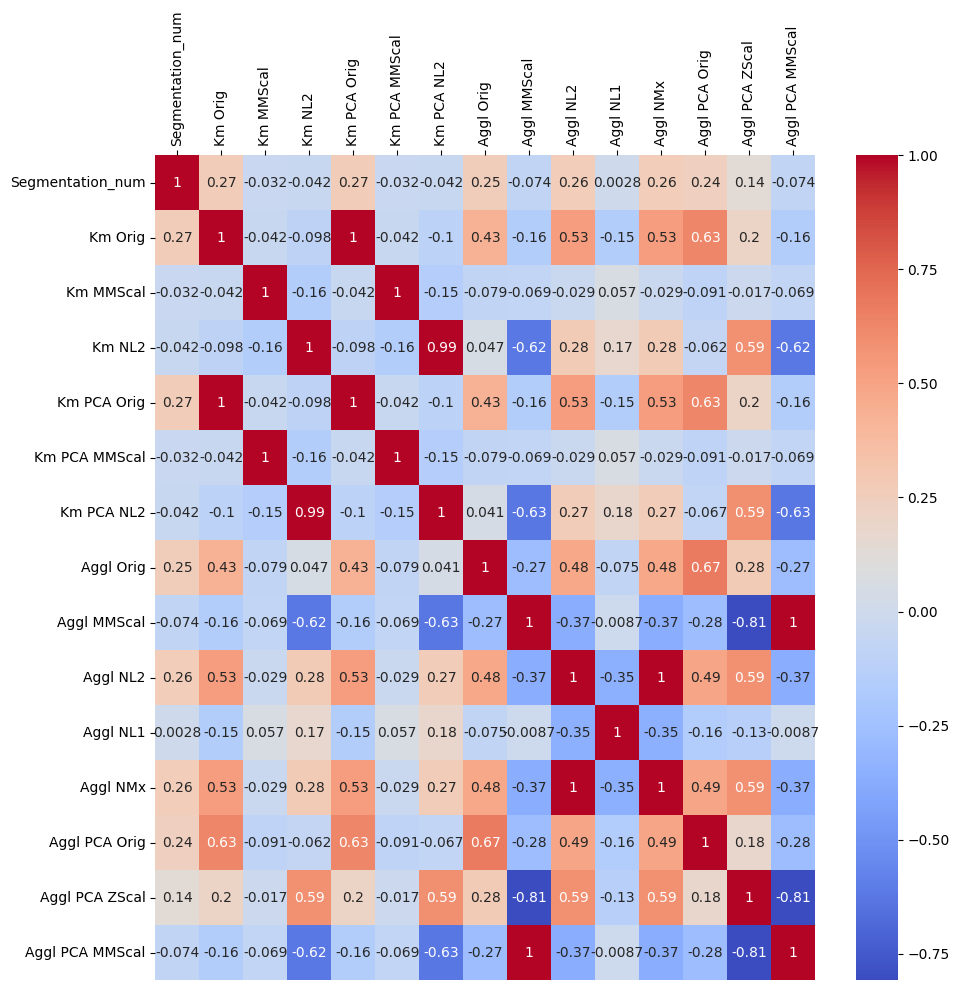

In [444]:
# correlation matrix of results
plt.figure(figsize=(10,10))
results_corr = results.drop(["Segmentation","ID"], axis = 1)
corr_matrix = results_corr.corr()
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.tight_layout()

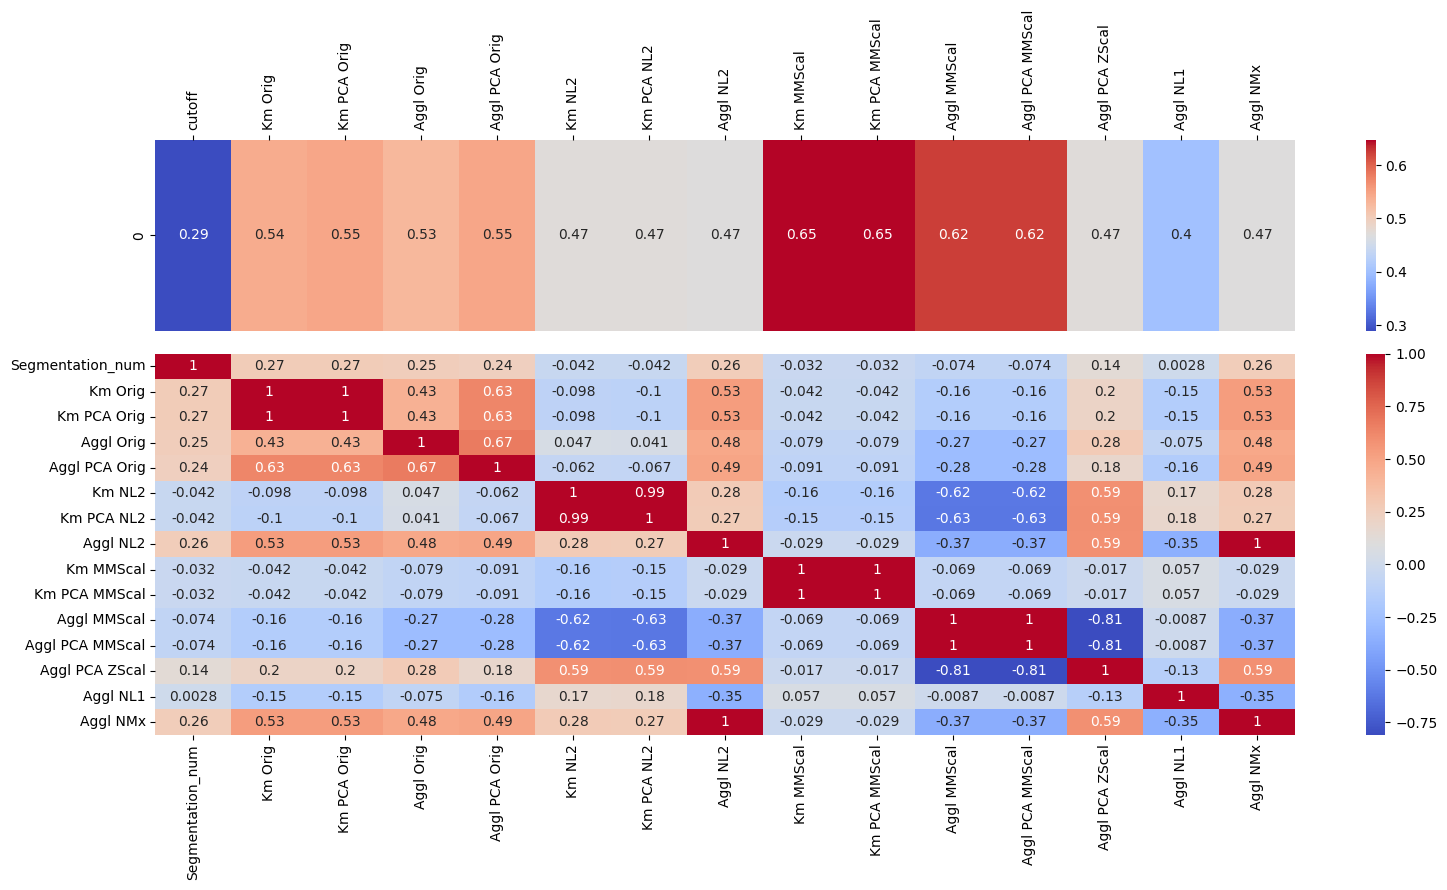

In [445]:
# correlation matrix of results - better ordered with shilouette scores

fig, axs = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [1, 2]})
shi_matrix = shilscore[["cutoff","Km Orig","Km PCA Orig","Aggl Orig","Aggl PCA Orig","Km NL2","Km PCA NL2","Aggl NL2",
                            "Km MMScal","Km PCA MMScal","Aggl MMScal","Aggl PCA MMScal","Aggl PCA ZScal","Aggl NL1","Aggl NMx"]]
ax = plt.subplot(2,1,1)
ax = sns.heatmap(shi_matrix, annot=True, cmap="coolwarm")
ax.xaxis.tick_top()
plt.xticks(rotation=90)

results_corr = results.drop(["Segmentation","ID"], axis = 1)
corr_matrix = results_corr[["Segmentation_num","Km Orig","Km PCA Orig","Aggl Orig","Aggl PCA Orig","Km NL2","Km PCA NL2","Aggl NL2",
                            "Km MMScal","Km PCA MMScal","Aggl MMScal","Aggl PCA MMScal","Aggl PCA ZScal","Aggl NL1","Aggl NMx"]].corr()
ax2 = plt.subplot(2,1,2)
ax2 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.tight_layout()




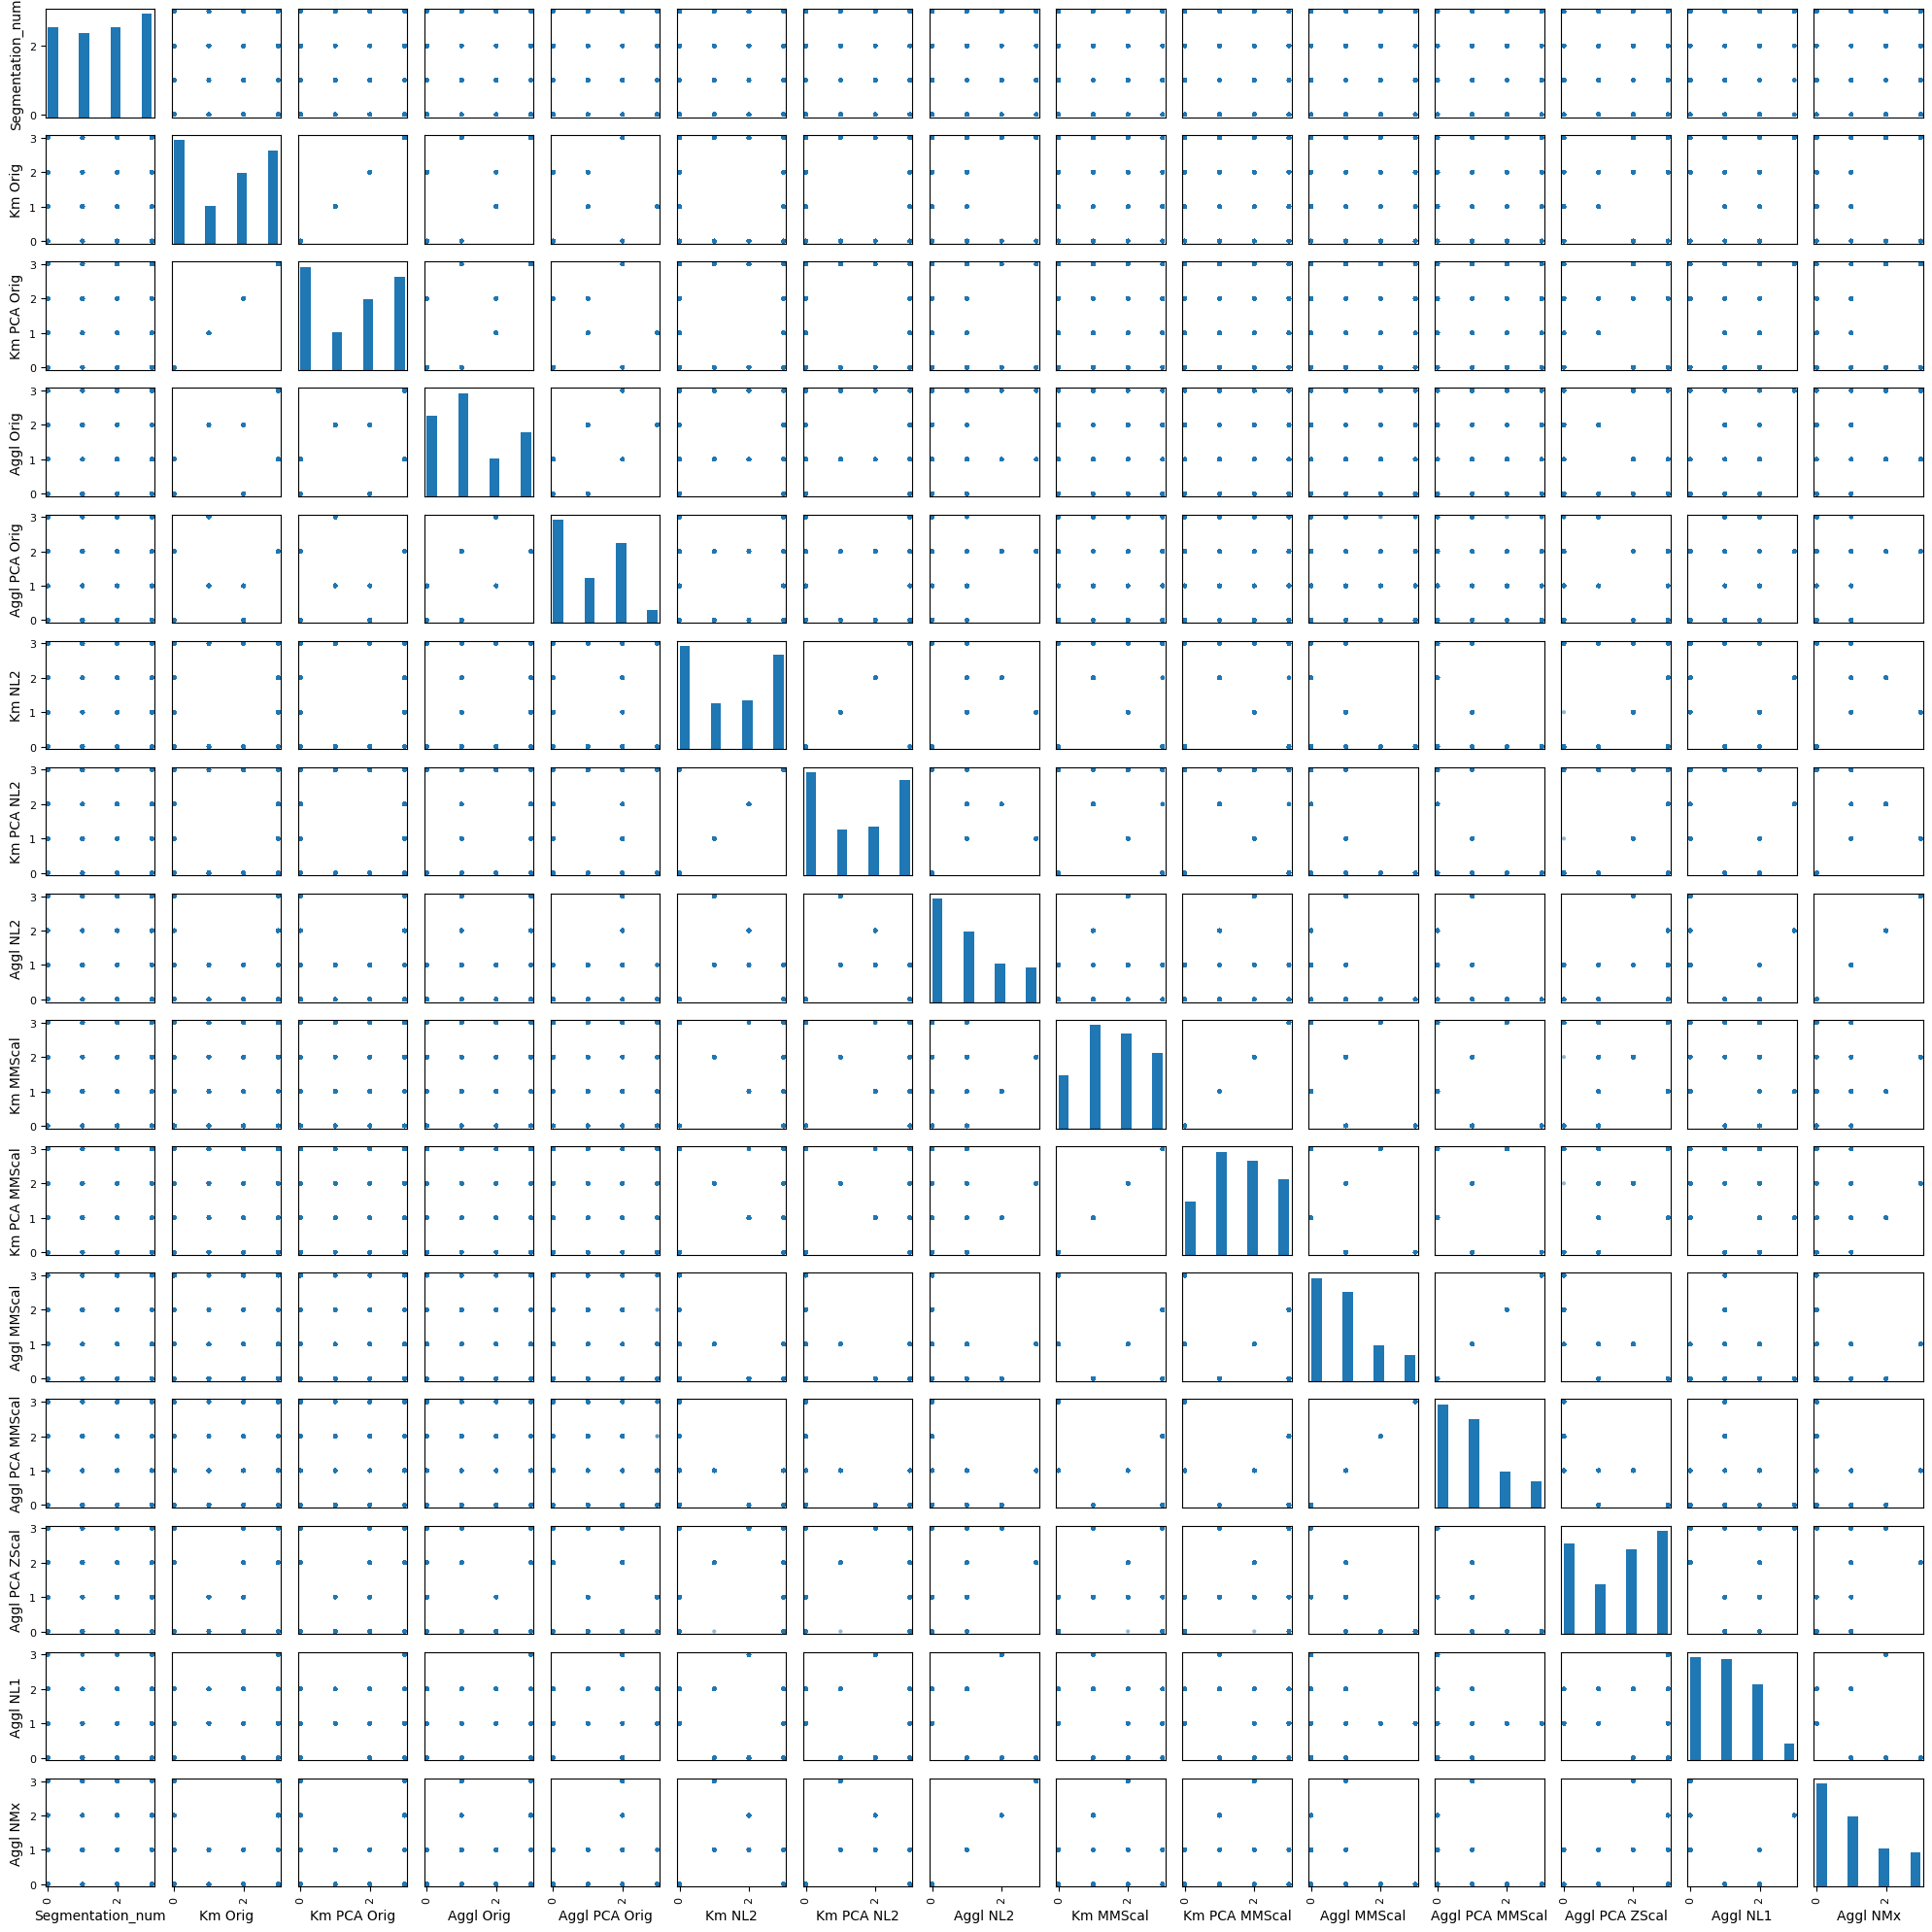

In [446]:
scat_matrix = results_corr[["Segmentation_num","Km Orig","Km PCA Orig","Aggl Orig","Aggl PCA Orig","Km NL2","Km PCA NL2","Aggl NL2",
                            "Km MMScal","Km PCA MMScal","Aggl MMScal","Aggl PCA MMScal","Aggl PCA ZScal","Aggl NL1","Aggl NMx"]]

# Generate scatter matrix comparable to correlation matrix 
# visualise the data relationships and the correlation numbers if presented beside each other 
scatter_matrix(scat_matrix, figsize=(20,20))

plt.tight_layout()

![alt text](https://github.com/Ddbol/Customer_Segmentation_Unsupervised_ML/blob/main/3feat_model_v_target_results.png?raw=true)

*# Due to the way GitHub handles URL's, if you do not append ?raw=true to the source URL your browser will attempt to load the page which displays the image.

# 4.3.1 Dendrogram Visualisation of subset data


{'icoord': [[5.0, 5.0, 15.0, 15.0], [25.0, 25.0, 35.0, 35.0], [45.0, 45.0, 55.0, 55.0], [30.0, 30.0, 50.0, 50.0], [10.0, 10.0, 40.0, 40.0], [65.0, 65.0, 75.0, 75.0], [95.0, 95.0, 105.0, 105.0], [85.0, 85.0, 100.0, 100.0], [70.0, 70.0, 92.5, 92.5], [25.0, 25.0, 81.25, 81.25], [125.0, 125.0, 135.0, 135.0], [115.0, 115.0, 130.0, 130.0], [145.0, 145.0, 155.0, 155.0], [122.5, 122.5, 150.0, 150.0], [185.0, 185.0, 195.0, 195.0], [175.0, 175.0, 190.0, 190.0], [165.0, 165.0, 182.5, 182.5], [136.25, 136.25, 173.75, 173.75], [53.125, 53.125, 155.0, 155.0]], 'dcoord': [[0.0, np.float64(1.0), np.float64(1.0), 0.0], [0.0, np.float64(1.0), np.float64(1.0), 0.0], [0.0, np.float64(1.0), np.float64(1.0), 0.0], [np.float64(1.0), np.float64(2.8284271247461903), np.float64(2.8284271247461903), np.float64(1.0)], [np.float64(1.0), np.float64(3.464101615137754), np.float64(3.464101615137754), np.float64(2.8284271247461903)], [0.0, np.float64(1.4142135623730951), np.float64(1.4142135623730951), 0.0], [0.0, np.

,Age,Gender_num,SpendSc_num
742,28,1,2
2127,29,0,0
2107,20,1,2
2943,51,1,0
4362,19,0,2
4441,36,1,0
6378,47,1,0
5091,39,1,0
1615,22,0,2
7966,30,1,2


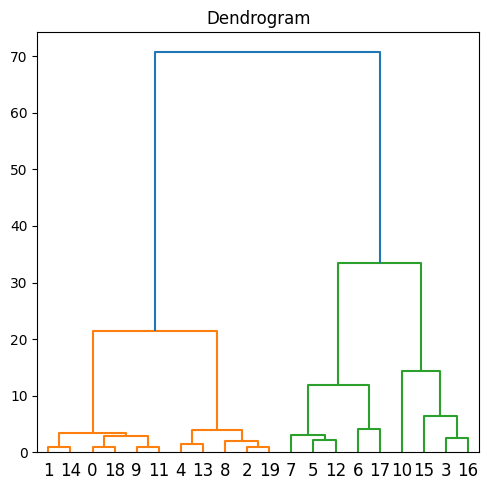

In [ ]:
# dendrogram to find the number of clusters - gives  a suggestion on where to break but you still decide whre to break
#limit variabilty
np.random.seed(42)
# small sample to plot dendogram - usually plot all but complex  - original model data unregularised
subset_data = model_data.sample(n=20)

plt.figure(figsize=(5,5))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(subset_data, method = "ward"))
plt.tight_layout()
print(dend)

subset_data

![alt text](https://github.com/Ddbol/Customer_Segmentation_Unsupervised_ML/blob/main/Cluster_visualisation.png?raw=true)

- 8 Feature Data in original workbook: refer to intro

*# Due to the way GitHub handles URL's, if you do not append ?raw=true to the source URL your browser will attempt to load the page which displays the image.

In [ ]:
# add back in expected and model given grouping to generate table. Taken to Excel and ordered as per dendrogram to give result above.
model_data_copy = model_data
model_data_copy["Segmentation"] = df_cleaned["Segmentation"]
model_data_copy["Segmentation_num"] = results["Segmentation_num"]
model_data_copy["Km Orig"] = results["Km Orig"]
model_data_copy["Aggl Orig"] = results["Aggl Orig"]
#limit variabilty
np.random.seed(42)
# small sample to plot dendogram - usually plot all but complex
subset_data = model_data_copy.sample(n=20)
subset_data

,Age,Gender_num,SpendSc_num,Segmentation,Segmentation_num,Km Orig,Aggl Orig
742,28,1,2,D,3,3,3
2127,29,0,0,A,0,3,3
2107,20,1,2,D,3,3,3
2943,51,1,0,C,2,2,0
4362,19,0,2,D,3,3,3
4441,36,1,0,C,2,0,1
6378,47,1,0,B,1,0,0
5091,39,1,0,A,0,0,1
1615,22,0,2,D,3,3,3
7966,30,1,2,C,2,3,1


# 4.3.2 Visualisation of Categories by feature
# 4.3.2.1 New Categries
Age appeared to have strongest correlation. Data index not changed between 2 tables below, can use model from one to look at features in the other. *Note not to add spaces to column names going forward

In [449]:
model_data_copy

,Age,Gender_num,SpendSc_num,Segmentation,Segmentation_num,Km Orig,Aggl Orig
0,22,1,2,D,3,3,3
1,38,0,0,A,0,0,1
2,67,0,2,B,1,1,2
3,67,1,1,B,1,1,2
4,40,0,1,A,0,0,1
...,...,...,...,...,...,...,...
8063,22,1,2,D,3,3,3
8064,35,1,2,D,3,0,1
8065,33,0,2,D,3,0,1
8066,27,0,2,B,1,3,3


In [450]:
reduced_data_orig_table

,PCA feat 1,PCA feat 2,KmPCAOrig,AgglPCAOrig
0,-21.473249,0.323387,3,2
1,-5.448231,-1.408187,0,0
2,23.521598,0.988026,1,1
3,23.536215,-0.057026,1,1
4,-3.462136,-0.381865,0,0
...,...,...,...,...
8063,-21.473249,0.323387,3,2
8064,-8.474477,0.502043,0,0
8065,-10.475190,0.520773,0,2
8066,-16.474623,0.438316,3,2


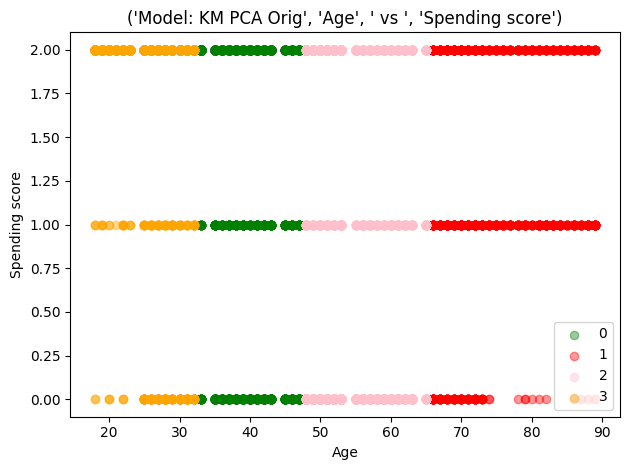

In [451]:
# Analyse contents of categories
# Scatter plot of clustering

df1 = model_data_copy[reduced_data_orig_table.KmPCAOrig==0]
df2 = model_data_copy[reduced_data_orig_table.KmPCAOrig==1]
df3 = model_data_copy[reduced_data_orig_table.KmPCAOrig==2]
df4 = model_data_copy[reduced_data_orig_table.KmPCAOrig==3]

var_x = "Age"
descrip_x = "Age"
var_y = "SpendSc_num"
descrip_y = "Spending score"
title = ("Model: KM PCA Orig", descrip_x," vs ",descrip_y)

plt.scatter(df1[var_x],df1[var_y],color = "green", alpha=0.4, label = 0)
plt.scatter(df2[var_x],df2[var_y],color = "red",alpha=0.4, label = 1)
plt.scatter(df3[var_x],df3[var_y],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4[var_x],df4[var_y],color = "orange", alpha=0.4,label = 3)
plt.xlabel(descrip_x)
plt.ylabel(descrip_y)
plt.legend()
plt.title(title)
plt.tight_layout()

Strong correlation of age to the different clusters (3 = approx 20-32, 1 = 65+)
Across the age brackets spending score seems relatively evenly disctributed between categories, except 1 and 3 seem to have less data at the lowest category of spending score.

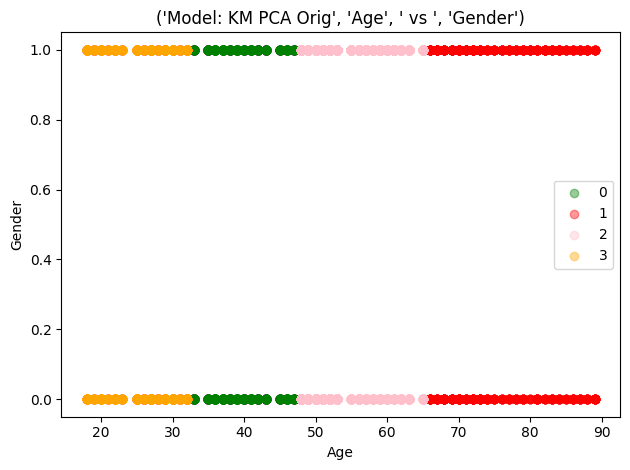

In [452]:
# Analyse contents of categories
# Scatter plot of clustering

df1 = model_data_copy[reduced_data_orig_table.KmPCAOrig==0]
df2 = model_data_copy[reduced_data_orig_table.KmPCAOrig==1]
df3 = model_data_copy[reduced_data_orig_table.KmPCAOrig==2]
df4 = model_data_copy[reduced_data_orig_table.KmPCAOrig==3]

var_x = "Age"
descrip_x = "Age"
var_y = "Gender_num"
descrip_y = "Gender"
title = ("Model: KM PCA Orig",descrip_x," vs ",descrip_y)

plt.scatter(df1[var_x],df1[var_y],color = "green", alpha=0.4, label = 0)
plt.scatter(df2[var_x],df2[var_y],color = "red",alpha=0.4, label = 1)
plt.scatter(df3[var_x],df3[var_y],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4[var_x],df4[var_y],color = "orange", alpha=0.4,label = 3)
plt.xlabel(descrip_x)
plt.ylabel(descrip_y)
plt.legend()
plt.title(title)
plt.tight_layout()

Strong correlation of age to the different clusters (3 = approx 20-32, 1 = 65+)
Across the age brackets gender seems relatively evenly disctributed between categories.

Plotted Histograms of numeric features of each category below and can see the clear age classification and associated data this pulls through. Can see that each category of the original A-D categories (Segmentation_num) are represented in the dataset to varying degrees and hence the low correlation between modeled and targetted segmentation (original A-D). 

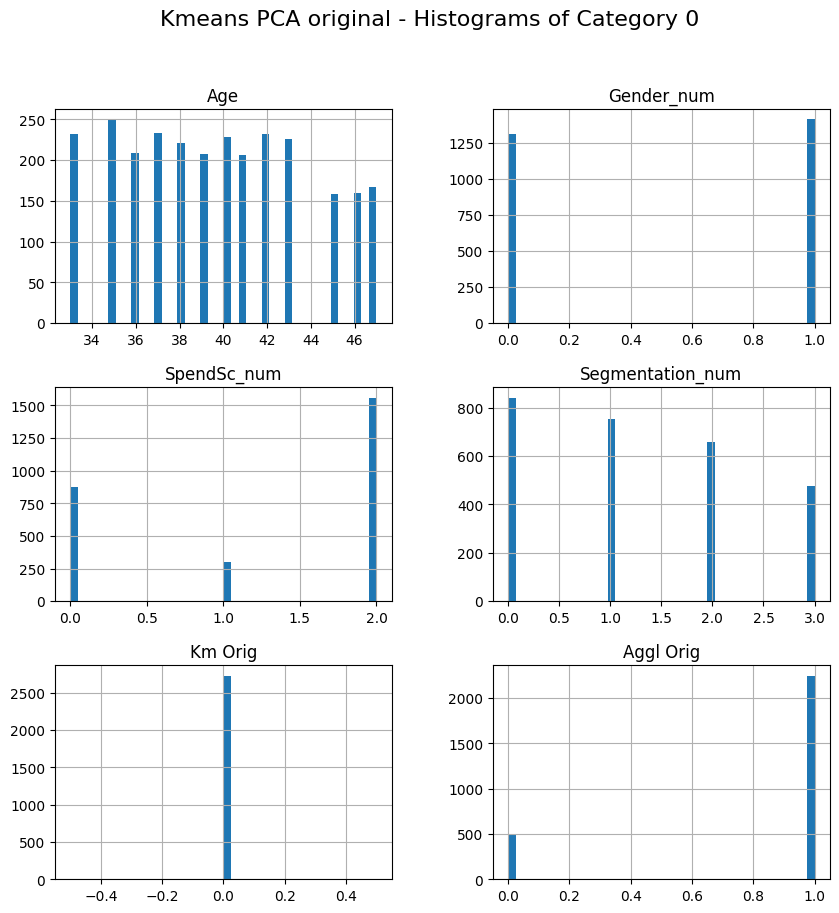

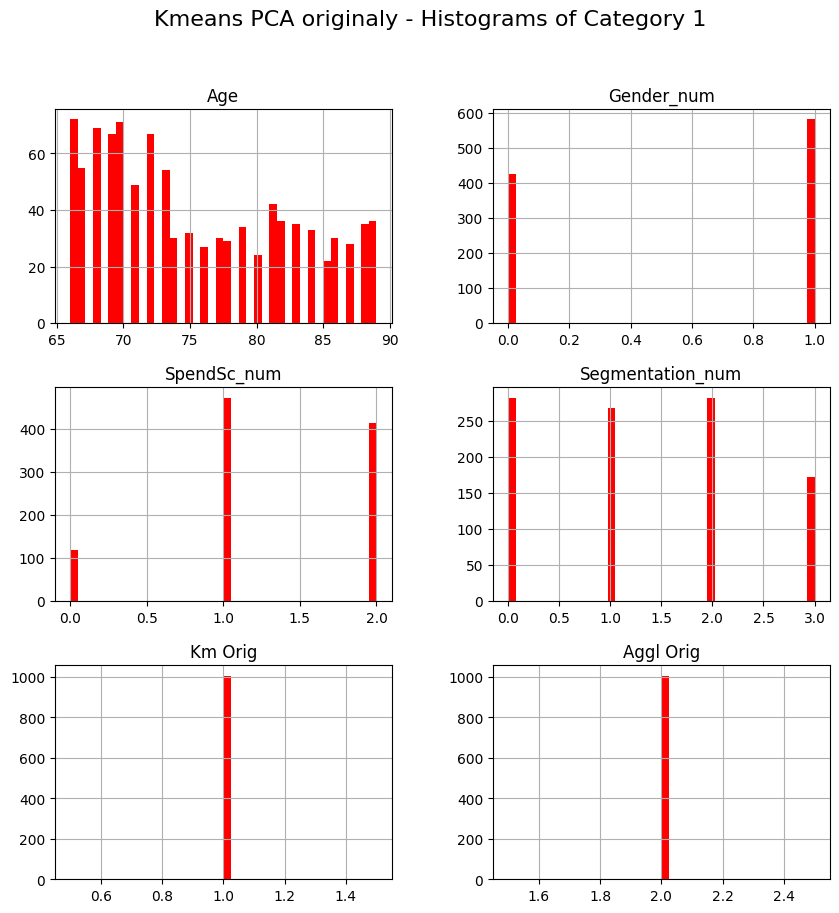

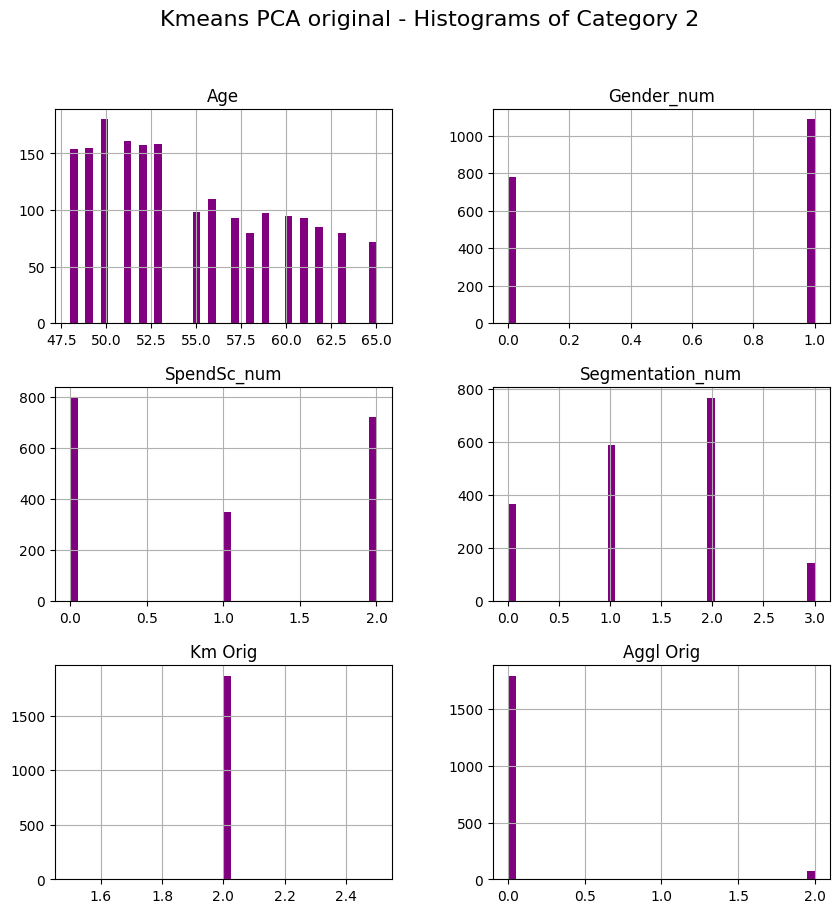

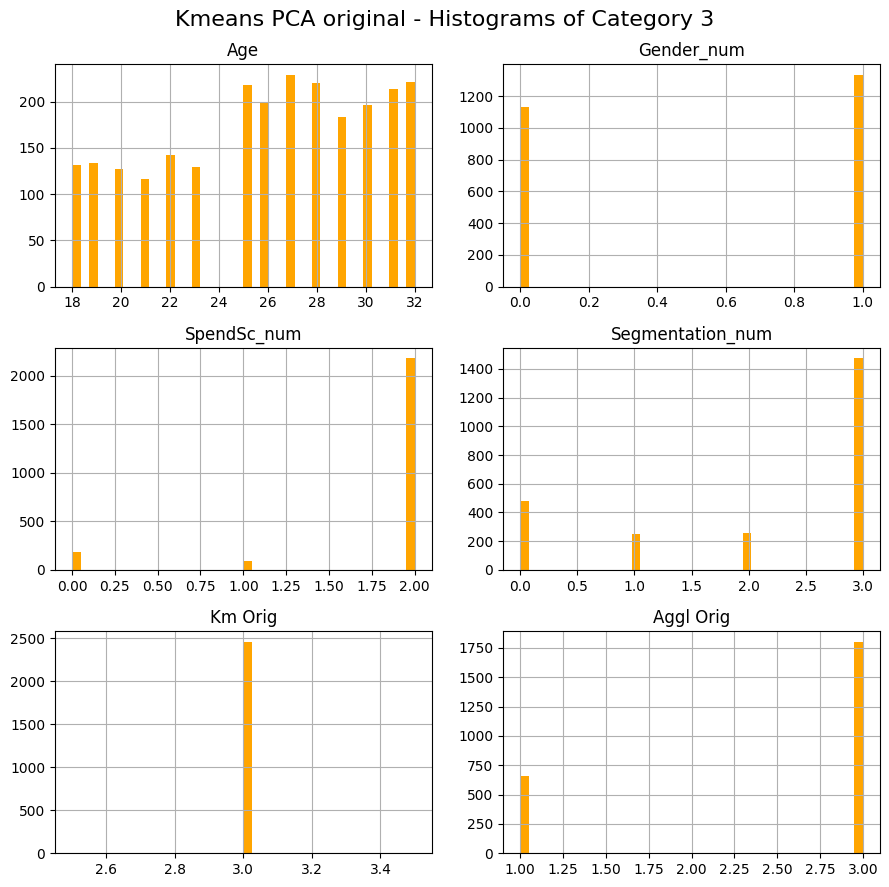

In [453]:
# Plot histograms of each category for Original A-D category

df1.hist(bins=40, figsize=(10,10))
plt.suptitle('Kmeans PCA original - Histograms of Category 0', fontsize=16)
df2.hist(bins=40,  figsize=(10,10), color = "red")
plt.suptitle('Kmeans PCA originaly - Histograms of Category 1', fontsize=16)
df3.hist(bins=40,  figsize=(10,10), color = "purple")
plt.suptitle('Kmeans PCA original - Histograms of Category 2', fontsize=16)
df4.hist(bins=40,  figsize=(9,9), color = "orange")
plt.suptitle('Kmeans PCA original - Histograms of Category 3', fontsize=16)

plt.tight_layout()


# 4.3.2.2 Old Categories
Compare same graph types for the pre-determined A-D Segmentation Classification. 

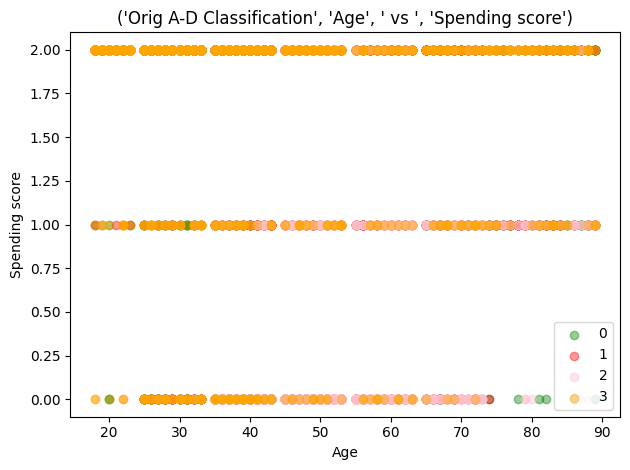

In [454]:
# Analyse contents of categories
# Scatter plot of clustering

df1 = df_cleaned[df_cleaned.Segmentation_num==0]
df2 = df_cleaned[df_cleaned.Segmentation_num==1]
df3 = df_cleaned[df_cleaned.Segmentation_num==2]
df4 = df_cleaned[df_cleaned.Segmentation_num==3]

var_x = "Age"
descrip_x = "Age"
var_y = "SpendSc_num"
descrip_y = "Spending score"
title = ("Orig A-D Classification",descrip_x," vs ",descrip_y)

plt.scatter(df1[var_x],df1[var_y],color = "green", alpha=0.4, label = 0)
plt.scatter(df2[var_x],df2[var_y],color = "red",alpha=0.4, label = 1)
plt.scatter(df3[var_x],df3[var_y],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4[var_x],df4[var_y],color = "orange", alpha=0.4,label = 3)
plt.xlabel(descrip_x)
plt.ylabel(descrip_y)
plt.legend()
plt.title(title)
plt.tight_layout()

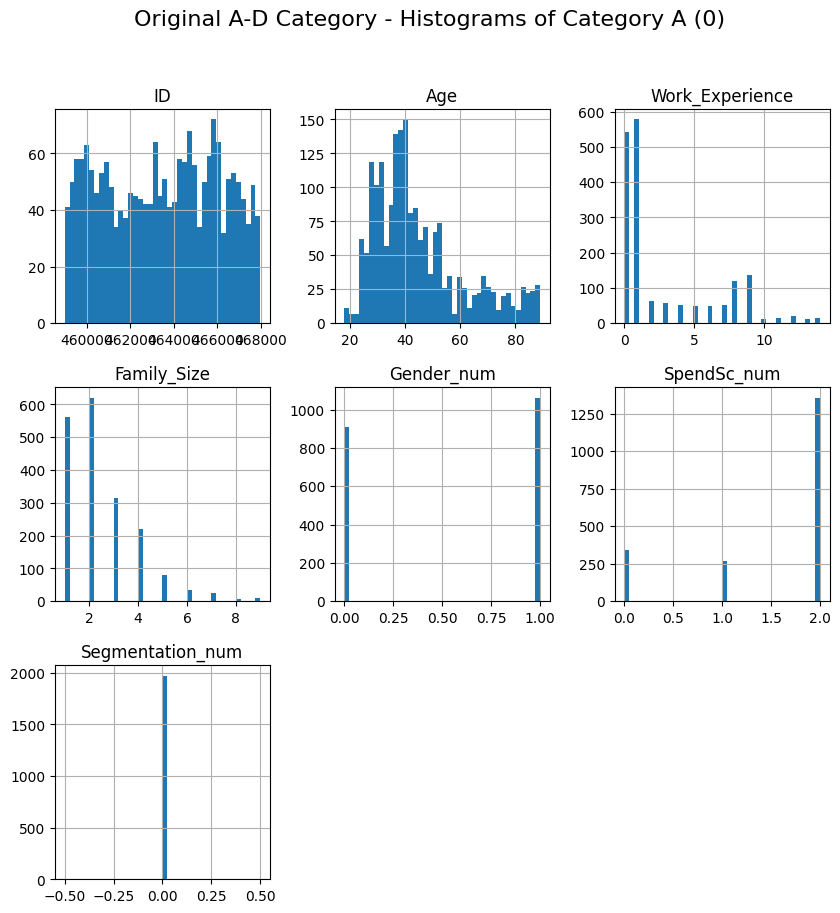

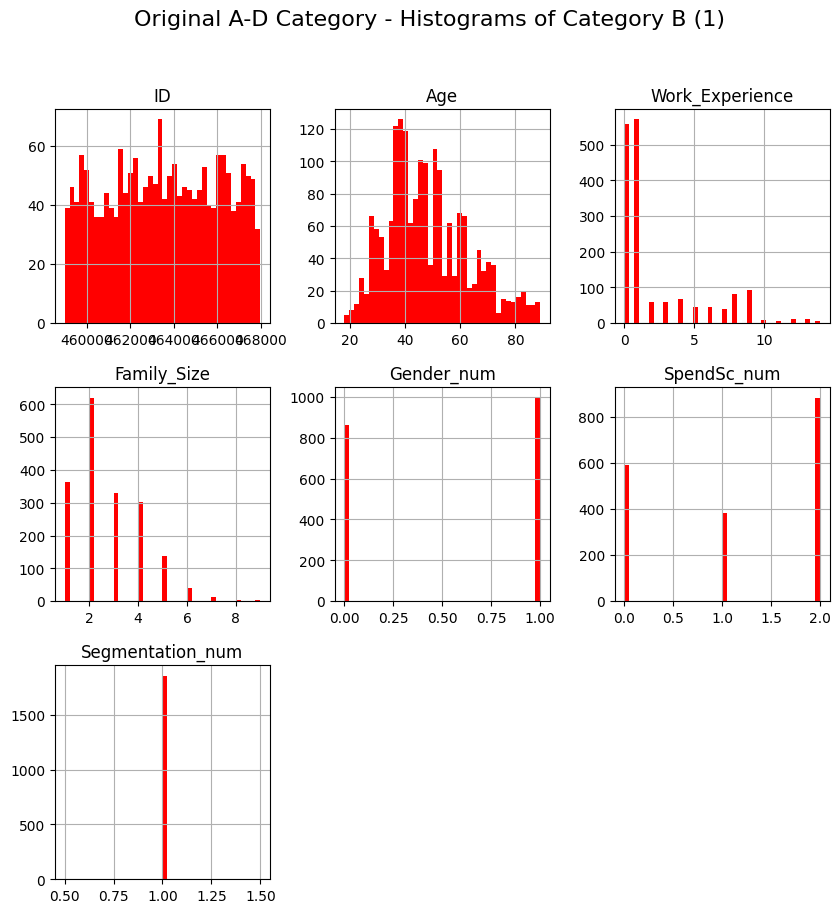

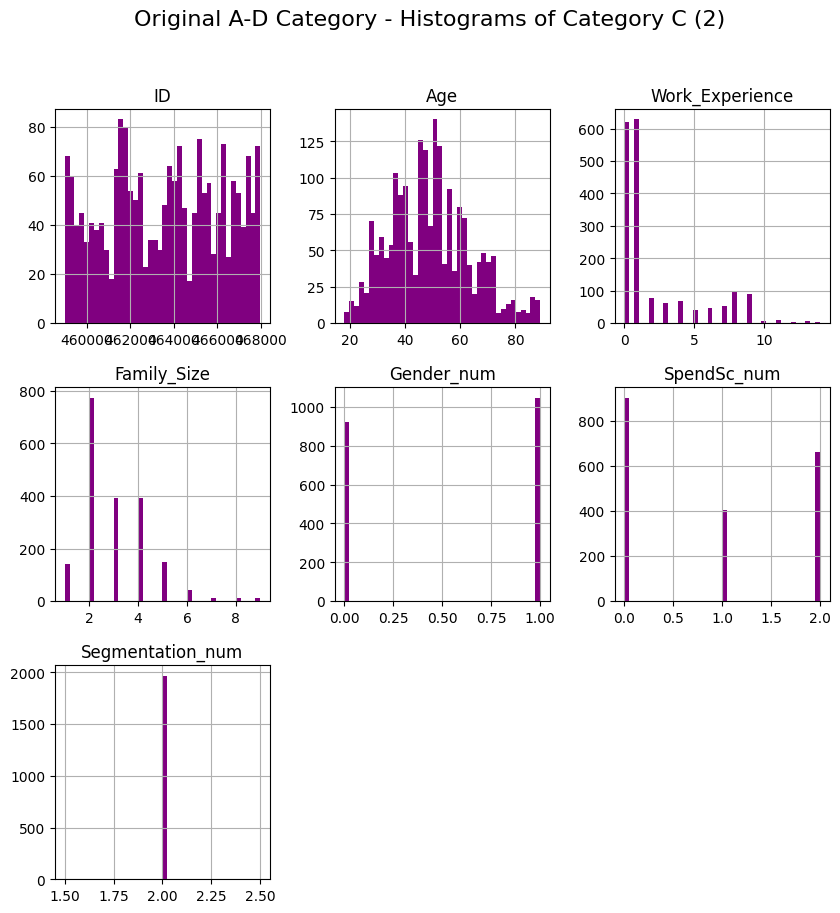

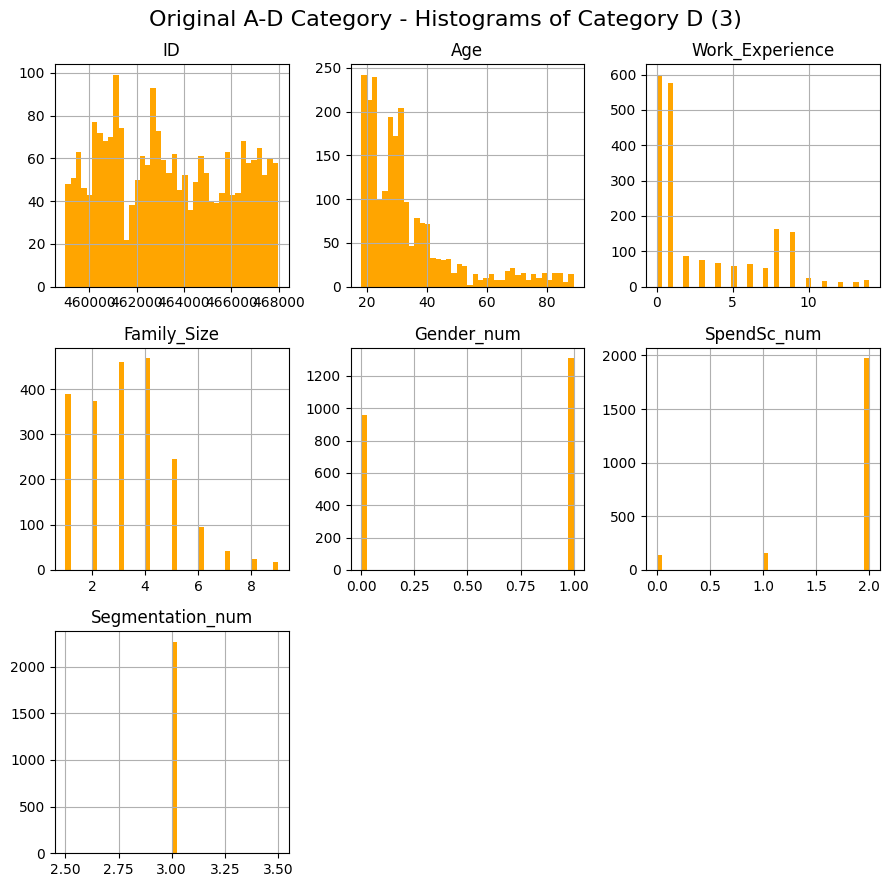

In [ ]:
# Plot histograms of each category for Original A-D category

df1.hist(bins=40, figsize=(10,10))
plt.suptitle('Original A-D Category - Histograms of Category A (0)', fontsize=16)
df2.hist(bins=40,  figsize=(10,10), color = "red")
plt.suptitle('Original A-D Category - Histograms of Category B (1)', fontsize=16)
df3.hist(bins=40,  figsize=(10,10), color = "purple")
plt.suptitle('Original A-D Category - Histograms of Category C (2)', fontsize=16)
df4.hist(bins=40,  figsize=(9,9), color = "orange")
plt.suptitle('Original A-D Category - Histograms of Category D (3)', fontsize=16)

plt.tight_layout()

Category 3 leans more towards younger ages but other categories data spread looks very similar making it so unable to model unsupervised. Likely explains why strongest shilouette was typically 2.

# 5 Conclusion
- Unsupervised learning was not able to reproduce existing A-D customer classification
    - (a)Visualised the unsupervised model of other features vs age and (b) visualised all numeric data as histograms for each individual category
        - age was the leading seperator in the unsupervised models but not in original A-D classification so can't reproduce
    - More domain knowledge required to replicate the categorisation 
        - oddities in work experience and spending score noted in data exploration
- Future work/improvements
    - Could have split dataset into training and test data with known answer
    - Iterative approach taken – function or pipeline would reduce coding lines for review